In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold, KFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge, RidgeCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, accuracy_score
import datetime
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score
import math


%matplotlib inline

print('Version de pandas: ', pd.__version__)
print('Version de seaborn: ', sns.__version__)

Version de pandas:  1.2.4
Version de seaborn:  0.11.0


In [2]:
# Chargement

Data2015 = pd.read_csv("Data2015_clean.csv")
Data2016 = pd.read_csv("Data2016_clean.csv")
Data = pd.read_csv("Data2015_2016_Clean2.csv")

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)

In [3]:
Data[['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType']] = Data[['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType']].astype('category')

In [4]:
Data.dtypes

OSEBuildingID                           int64
DataYear                                int64
BuildingType                         category
PrimaryPropertyType                  category
NumberofBuildings                     float64
NumberofFloors                        float64
PropertyGFATotal                        int64
PropertyGFAParking                      int64
PropertyGFABuilding(s)                  int64
LargestPropertyUseType               category
LargestPropertyUseTypeGFA             float64
ENERGYSTARScore                       float64
SiteEnergyUse(kBtu)                   float64
SteamUse(kBtu)                        float64
Electricity(kBtu)                     float64
NaturalGas(kBtu)                      float64
Latitude                              float64
Longitude                             float64
TotalGHGEmissions                     float64
GHGEmissionsIntensity                 float64
SiteEnergyUse(kBtu)_Standardiser      float64
totalGHGEmissions_Standardisation 

In [5]:
Data.describe()

,OSEBuildingID,DataYear,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Latitude,Longitude,TotalGHGEmissions,GHGEmissionsIntensity,SiteEnergyUse(kBtu)_Standardiser,totalGHGEmissions_Standardisation
count,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1.524000e+03,1.524000e+03,1.524000e+03,1.524000e+03,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000
mean,15680.515092,2015.496719,1.002625,3.465879,77638.263123,7002.487533,70635.775591,66481.235564,65.250656,3.929520e+06,8.146908e+04,2.839556e+06,1.001302e+06,47.616655,-122.333153,79.262736,1.108163,14.665835,3.681341
std,12616.584061,0.500153,0.201748,4.797626,76236.411910,19684.585828,68322.779589,62414.563159,27.996556,4.470059e+06,5.052338e+05,3.826608e+06,1.556675e+06,0.050635,0.025584,98.774237,1.309746,1.031148,1.267996
min,1.000000,2015.000000,0.000000,0.000000,12294.000000,0.000000,-43310.000000,8061.000000,1.000000,1.131300e+05,0.000000e+00,6.138000e+03,0.000000e+00,47.499170,-122.411820,1.060000,0.010000,11.636293,0.058269
25%,599.750000,2015.000000,1.000000,1.000000,29619.000000,0.000000,28498.000000,26410.750000,49.000000,1.158625e+06,0.000000e+00,6.824052e+05,0.000000e+00,47.580807,-122.345352,17.407500,0.240000,13.962743,2.856901
50%,20977.500000,2015.000000,1.000000,2.000000,48630.000000,0.000000,46512.000000,44417.000000,73.000000,2.146308e+06,0.000000e+00,1.392957e+06,4.232335e+05,47.613600,-122.333000,42.005000,0.700000,14.579260,3.737788
75%,24288.750000,2016.000000,1.000000,4.000000,92849.000000,0.000000,84217.500000,78840.500000,88.000000,5.011760e+06,0.000000e+00,3.329842e+06,1.187878e+06,47.655757,-122.321258,98.085000,1.462500,15.427297,4.585832
max,50222.000000,2016.000000,5.000000,99.000000,538933.000000,118744.000000,508160.000000,425829.000000,100.000000,2.805317e+07,6.568832e+06,2.713719e+07,1.143964e+07,47.733811,-122.258640,653.500000,13.880000,17.149612,6.482343


Nous avons bien récupérer nos datasets après le travail effectué dessus, nous allons préparé les données afin de pouvoir utiliser RandomForestRegressor.

Comme nous cherchons à estimer les variables 'SiteEnergyUse' et 'TotalGHGEmissions', ce sera nos targets y par rapport a X, le reste des variables formera X.

Dans un premier temps nous allons encoder nos données en données et les normaliser, nous pouvons voir que nos variables ont des plages de valeurs très différentes, ainsi que des distributions différentes.

In [6]:
y = Data[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)_Standardiser', 'totalGHGEmissions_Standardisation']].copy()
X = Data.drop(['OSEBuildingID', 'DataYear', 'SiteEnergyUse(kBtu)', 'Longitude', 'Latitude', 'TotalGHGEmissions', 'totalGHGEmissions_Standardisation','ENERGYSTARScore', 'SiteEnergyUse(kBtu)_Standardiser'], axis = 1).copy()

In [7]:
colonneCategory = X.select_dtypes(['category', 'object']).columns
colonneNumérique = X.select_dtypes(['int64','float64']).columns

std = StandardScaler()
X[colonneNumérique] = std.fit_transform(X[colonneNumérique])
onehot_encoder = OneHotEncoder(sparse=False)
#integer_encoded = integer_encoded.reshape(X[colonneObject], 1)
onehot_encoded = onehot_encoder.fit_transform(X[colonneCategory])

X = pd.merge(X, pd.DataFrame(columns = onehot_encoder.get_feature_names().tolist(),
                                               data = onehot_encoded),
                                               left_index = True,
                                               right_index = True)

In [8]:
X.describe() 

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity,x0_2,x0_3,x0_4,x1_1,x1_2,x1_3,x1_4,x1_5,x2_1,x2_2,x2_3,x2_4,x2_5,x2_6
count,1.524000e+03,1.524000e+03,1.524000e+03,1.524000e+03,1.524000e+03,1.524000e+03,1.524000e+03,1.524000e+03,1.524000e+03,1.524000e+03,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000,1524.000000
mean,-2.556463e-16,-4.089759e-16,2.129384e-16,1.808338e-15,2.259056e-16,1.678447e-16,2.079483e-16,-1.696660e-16,-2.869169e-16,1.369566e-17,0.986220,0.009186,0.004593,0.501969,0.251312,0.152231,0.063648,0.030840,0.271654,0.582677,0.049213,0.063648,0.032152,0.000656
std,1.000328e+00,1.000328e+00,1.000328e+00,1.000328e+00,1.000328e+00,1.000328e+00,1.000328e+00,1.000328e+00,1.000328e+00,1.000328e+00,0.116613,0.095436,0.067639,0.500160,0.433910,0.359363,0.244205,0.172941,0.444958,0.493279,0.216383,0.244205,0.176462,0.025616
min,-4.971321e+00,-7.226525e-01,-8.574080e-01,-3.558513e-01,-1.668304e+00,-9.363105e-01,-1.613032e-01,-7.406945e-01,-6.434424e-01,-8.387299e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.301393e-02,-5.141477e-01,-6.300798e-01,-3.558513e-01,-6.169481e-01,-6.422161e-01,-1.613032e-01,-5.639089e-01,-6.434424e-01,-6.630657e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.301393e-02,-3.056429e-01,-3.806289e-01,-3.558513e-01,-3.532013e-01,-3.536271e-01,-1.613032e-01,-3.781609e-01,-3.714702e-01,-3.117373e-01,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,-1.301393e-02,1.113667e-01,1.995861e-01,-3.558513e-01,1.988529e-01,1.980839e-01,-1.613032e-01,1.281677e-01,1.198944e-01,2.706277e-01,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.982021e+01,1.991932e+01,6.052831e+00,5.678463e+00,6.405885e+00,5.759324e+00,1.284453e+01,6.351736e+00,6.707730e+00,9.754585e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y['SiteEnergyUse(kBtu)_Standardiser'], test_size = 0.3, random_state = 42)

# Prédiction consommation totale d'énergie

### Baseline

### Importance des variables pour SiteEnergyUse

Nous allons regarder l'impact des variables sur nos résultats, quelles sont les variables qui interviennent le plus.

Pour les différents entraînements nous utiliserons la cross validation, que nous allons définir maintenant:

In [10]:
np.random.seed(5)
cv_train = KFold(n_splits = 5, shuffle = True, random_state = 45)
score = ('r2','neg_mean_absolute_error')

Regardons dans un premier temps ce que donne la régression linéaire avec et sans les features créées par OneHotEncoder:

In [11]:
XTest = X.copy()
XTest.drop(['x0_2', 'x0_3', 'x0_4', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x2_1', 'x2_2', 'x2_3','x2_4', 'x2_5','x2_6'], axis = 1, inplace = True)

In [12]:
X_train_withoutF, X_test_withoutF, y_train_withoutF, y_test_withoutF = train_test_split(XTest, y['SiteEnergyUse(kBtu)_Standardiser'], test_size = 0.3, random_state = 42)

In [13]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_withoutF = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )


gs_linearRegression_withoutF.fit(X_train_withoutF, y_train_withoutF)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [14]:
print("MSE : ", mean_squared_error(y_test_withoutF, gs_linearRegression_withoutF.predict(X_test_withoutF))) 
print("RMSE : ", math.sqrt(mean_squared_error(y_test_withoutF, gs_linearRegression_withoutF.predict(X_test_withoutF))))

y_pred_withoutF = gs_linearRegression_withoutF.predict(X_test_withoutF)

print("MAE Train: ", mae(y_train_withoutF, gs_linearRegression_withoutF.predict(X_train_withoutF)))
print("MAE Test: ", mae(y_test_withoutF, gs_linearRegression_withoutF.predict(X_test_withoutF)), '\n')

MSE :  0.24737731146592473
RMSE :  0.49737039665215776
MAE Train:  0.36589800087469976
MAE Test:  0.38904565062168106 



Nous pouvons imaginer que les variables qui interviennent le plus sont les différentes énergies, ce qui est logique puisque la variable SiteEnergyUse va dépendre de ces variables principalement, cependant ce sont des variables qui vont être assez difficile et cher à obtenir, nous allons les mettre de côté afin de voir comment évolue notre modèle.

In [15]:
XTest = X.copy()
XTest.drop(['Electricity(kBtu)','NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'SteamUse(kBtu)'], axis = 1, inplace = True)

In [16]:
X_train_withoutEnergy, X_test_withoutEnergy, y_train_withoutEnergy, y_test_withoutEnergy = train_test_split(XTest, y['SiteEnergyUse(kBtu)_Standardiser'], test_size = 0.3, random_state = 42)

In [17]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_withoutEnergy = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,                  
                  n_jobs = -1
                 )


gs_linearRegression_withoutEnergy.fit(X_train_withoutEnergy, y_train_withoutEnergy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [18]:
y_pred_withoutEnergy = gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy)

print("MSE : ", mean_squared_error(y_test_withoutEnergy, gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test_withoutEnergy, gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy))), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test_withoutEnergy), np.exp(gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test_withoutEnergy), np.exp(gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy)))))

MSE :  0.4152922165830855
RMSE :  0.6444317004796439 

"Erreur réelle: "

MSE réelle:  33508502031053.92
RMSE réelle:  5788652.868418862


Regardons pour finir si nous retirons les features créés par OneHotEncoder et les énergies:

In [19]:
XTest = X.copy()
XTest.drop(['Electricity(kBtu)','NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'SteamUse(kBtu)', 'x0_2', 'x0_3', 'x0_4', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5','x2_6'], axis = 1, inplace = True)

In [20]:
X_train_withoutEnergyF, X_test_withoutEnergyF, y_train_withoutEnergyF, y_test_withoutEnergyF = train_test_split(XTest, y['SiteEnergyUse(kBtu)_Standardiser'], test_size = 0.3, random_state = 42)

In [21]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_withoutEnergyF = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,                  
                  n_jobs = -1
                 )


gs_linearRegression_withoutEnergyF.fit(X_train_withoutEnergyF, y_train_withoutEnergyF)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [22]:
y_pred_withoutEnergyF = gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF)

print("MSE : ", mean_squared_error(y_test_withoutEnergyF, gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test_withoutEnergyF, gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF))), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test_withoutEnergyF), np.exp(gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test_withoutEnergyF), np.exp(gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF)))))

MSE :  0.4374197394856391
RMSE :  0.6613771537372901 

"Erreur réelle: "

MSE réelle:  37176741395882.086
RMSE réelle:  6097273.275479957


Dans un premier temps nous allons effectuer une régression linéaire classique afin de récupérer une erreur baseline, qu'on cherchera à améliorer à l'aide de différentes techniques de régularisation.

class (*, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None, positive=Falsesklearn.linear_model.LinearRegression)

In [23]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )


gs_linearRegression.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [24]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_linearRegression.best_params_)

Nous avons les meilleurs résultats avec les paramètres: 
 {'fit_intercept': 'True', 'normalize': 'True'}


In [25]:
print("MSE : ", mean_squared_error(y_test, gs_linearRegression.predict(X_test))) 
print("RMSE : ", math.sqrt(mean_squared_error(y_test, gs_linearRegression.predict(X_test))))

y_pred = gs_linearRegression.predict(X_test)

print("MAE Train: ", mae(y_train, gs_linearRegression.predict(X_train)))
print("MAE Test: ", mae(y_test, gs_linearRegression.predict(X_test)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test), np.exp(gs_linearRegression.predict(X_test)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test), np.exp(gs_linearRegression.predict(X_test)))))
print("MAE Train réelle: ", mae(np.exp(y_train), np.exp(gs_linearRegression.predict(X_train))))
print("MAE Test réelle: ", mae(np.exp(y_test), np.exp(gs_linearRegression.predict(X_test))))

MSE :  0.22313566189433365
RMSE :  0.4723723763032018
MAE Train:  0.34788613782867744
MAE Test:  0.37273131863297726 

"Erreur réelle: "

MSE réelle:  77743843441666.95
RMSE réelle:  8817246.930968132
MAE Train réelle:  1845509.1913027582
MAE Test réelle:  2114242.393846334


Nous pouvons voir que pour le modèle de regression linéaire il est plus intéressant de prendre toutes les variables, nous pouvons aussi voir que les énergies jouent un rôle non négligeable, regardons ce que ça donne si on ne garde que les énergies:

In [26]:
XTest = X.copy()
XTest.drop(['BuildingType', 'PrimaryPropertyType', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'x0_2', 'x0_3', 'x0_4', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5','x2_6'], axis = 1, inplace = True)

In [27]:
X_train_OnlyEnergy, X_test_OnlyEnergy, y_train_OnlyEnergy, y_test_OnlyEnergy = train_test_split(XTest, y['SiteEnergyUse(kBtu)_Standardiser'], test_size = 0.3, random_state = 42)

In [28]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_OnlyEnergy = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,                  
                  n_jobs = -1
                 )


gs_linearRegression_OnlyEnergy.fit(X_train_OnlyEnergy, y_train_OnlyEnergy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [29]:
y_pred_OnlyEnergy = gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy)

print("MSE : ", mean_squared_error(y_test_OnlyEnergy, y_pred_OnlyEnergy)) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test_OnlyEnergy, y_pred_OnlyEnergy)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test_OnlyEnergy), np.exp(gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test_OnlyEnergy), np.exp(gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy)))))

MSE :  0.28558125994290356
RMSE :  0.5343980351226074 

"Erreur réelle: "

MSE réelle:  172291213005139.25
RMSE réelle:  13125974.74495282


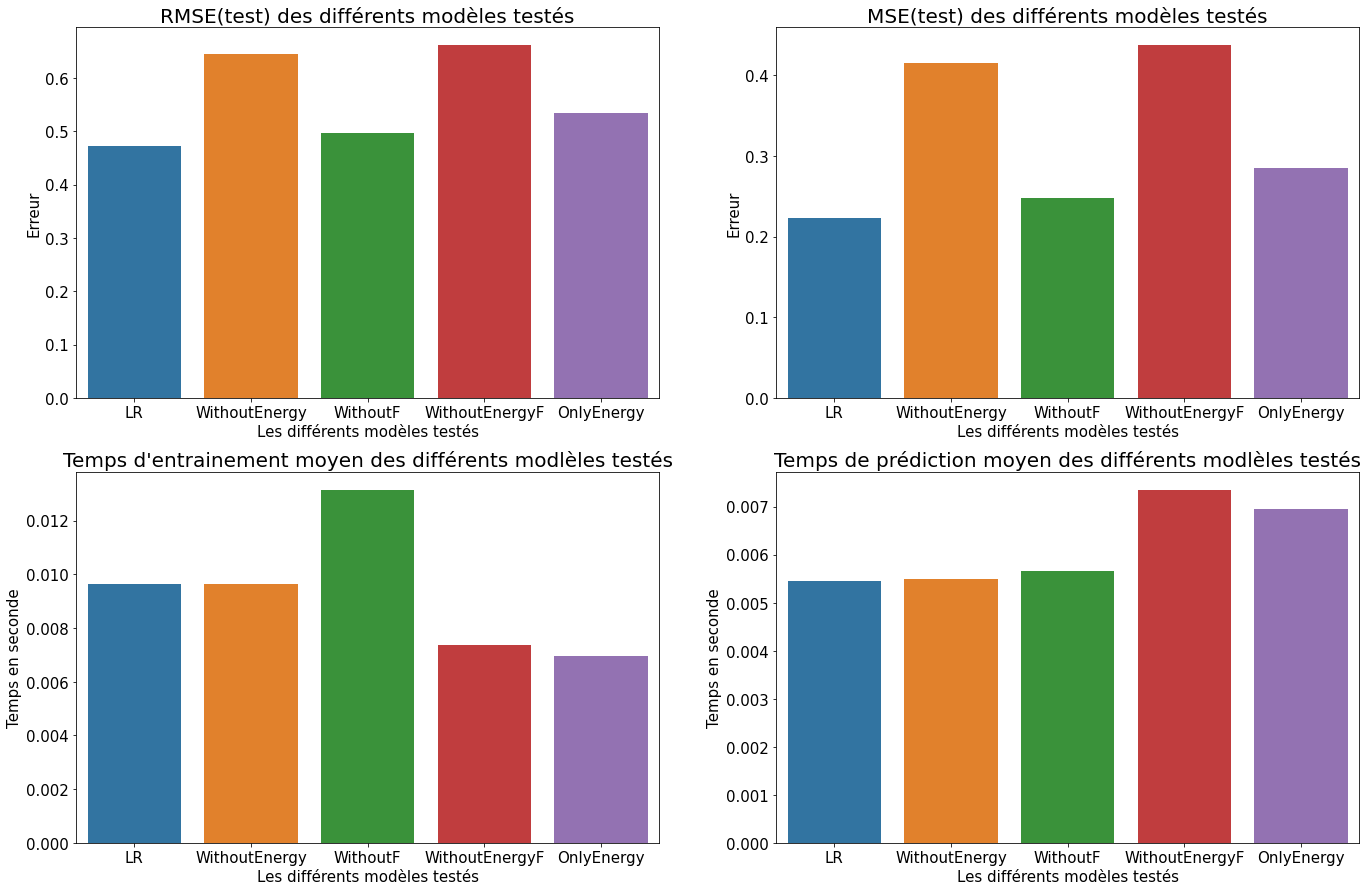

In [30]:
fig = plt.figure(figsize = (23, 15))

listeModeles = ['LR', 'WithoutEnergy', 'WithoutF', 'WithoutEnergyF', 'OnlyEnergy']

listeRMSE = [math.sqrt(mean_squared_error(y_test, gs_linearRegression.predict(X_test))), math.sqrt(mean_squared_error(y_test_withoutEnergy, y_pred_withoutEnergy)), math.sqrt(mean_squared_error(y_test_withoutF, y_pred_withoutF)), math.sqrt(mean_squared_error(y_test_withoutEnergyF, y_pred_withoutEnergyF)), math.sqrt(mean_squared_error(y_test_OnlyEnergy, y_pred_OnlyEnergy))]
listeMSE = [mean_squared_error(y_test, gs_linearRegression.predict(X_test)), mean_squared_error(y_test_withoutEnergy, y_pred_withoutEnergy), mean_squared_error(y_test_withoutF, y_pred_withoutF), mean_squared_error(y_test_withoutEnergyF, y_pred_withoutEnergyF), mean_squared_error(y_test_OnlyEnergy, y_pred_OnlyEnergy)]
listeFitTime = [gs_linearRegression.cv_results_['mean_fit_time'].mean(), gs_linearRegression_withoutEnergy.cv_results_['mean_fit_time'].mean(), gs_linearRegression_withoutF.cv_results_['mean_fit_time'].mean(), gs_linearRegression_withoutEnergyF.cv_results_['mean_fit_time'].mean(), gs_linearRegression_OnlyEnergy.cv_results_['mean_fit_time'].mean()]
listePredictTime = [gs_linearRegression.cv_results_['mean_score_time'].mean(), gs_linearRegression_withoutEnergy.cv_results_['mean_score_time'].mean(), gs_linearRegression_withoutF.cv_results_['mean_score_time'].mean(), gs_linearRegression_withoutEnergyF.cv_results_['mean_fit_time'].mean(), gs_linearRegression_OnlyEnergy.cv_results_['mean_fit_time'].mean()]


plt.subplot(2,2,1)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Temps en seconde', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,4)
sns.barplot(x = listeModeles, y = listePredictTime)
plt.title('Temps de prédiction moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Temps en seconde', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)


La encore il est préférable de prendre toutes les variables disponible pour avoir de meilleur RMSE et MSE, cependant nous pouvons voir aussi qu'il n'y a pas un grande différence entre l'utilisation de toutes les variables et l'utilisation de l'énergie uniquement, regardons la différence de plus près:

In [31]:
DifferenceAllvsWithoutF = abs(math.sqrt(mean_squared_error(y_test, gs_linearRegression.predict(X_test))) - math.sqrt(mean_squared_error(y_test_withoutF, y_pred_withoutF))) / math.sqrt(mean_squared_error(y_test_withoutF, y_pred_withoutF)) *100 
DifferenceAllvsOnlyEnergy = abs(math.sqrt(mean_squared_error(y_test, gs_linearRegression.predict(X_test))) - math.sqrt(mean_squared_error(y_test_OnlyEnergy, y_pred_OnlyEnergy))) / math.sqrt(mean_squared_error(y_test_OnlyEnergy, y_pred_OnlyEnergy)) * 100

print(DifferenceAllvsWithoutF)
print(DifferenceAllvsOnlyEnergy)

5.026037037431213
11.606640508170102


Nous pouvons voir qu'on a une légère différence en ce qui concerne la RMSE sur un modèle simple comme la regression linéaire, nous pouvons être en droit d'imaginer que cette différence va diminuer avec la complexité du modèle avec un gain non négligeable en terme de temps, pour la suite nous n'utiliserons que les énergies.

In [32]:
X1 = X.copy()
X1.drop(['BuildingType', 'PrimaryPropertyType', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'x0_2', 'x0_3', 'x0_4', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5','x2_6'], axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X1, y['SiteEnergyUse(kBtu)_Standardiser'], test_size = 0.3, random_state = 42)

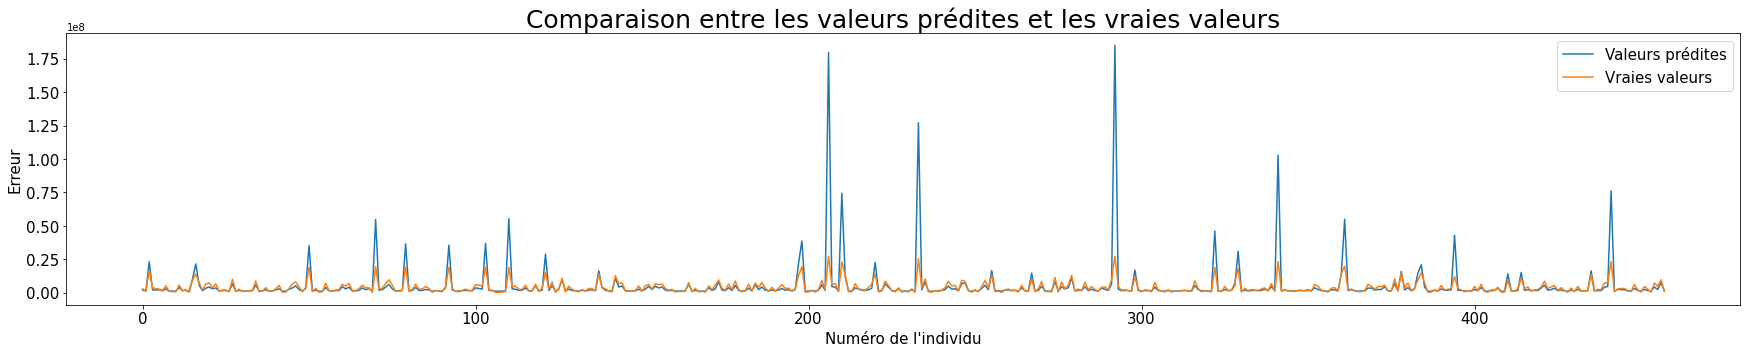

In [33]:
fig = plt.figure(figsize = (30, 5))
plt.title('Comparaison entre les valeurs prédites et les vraies valeurs', fontsize = 25)
plt.plot(np.exp(list(y_pred_OnlyEnergy)))
plt.plot(np.exp(list(y_test_OnlyEnergy)))
plt.legend(["Valeurs prédites", "Vraies valeurs"], loc = "upper right", fontsize = 15)
plt.xlabel('Numéro de l\'individu', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

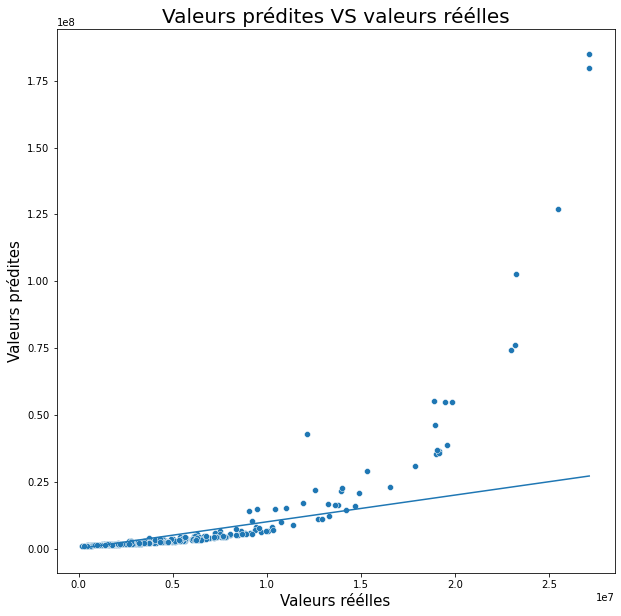

In [34]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_test_OnlyEnergy), y = np.exp(y_pred_OnlyEnergy))
plt.plot([np.exp(y_test_OnlyEnergy).min(), np.exp(y_test_OnlyEnergy).max()], [np.exp(y_test_OnlyEnergy).min(), np.exp(y_test_OnlyEnergy).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

Nous pouvons voir qu'un "outlier" peut exister, regardons ce que nous obtenons si cet "outlier" n'est plus là:

In [35]:
y_testWithoutOutlier = y_test_OnlyEnergy.copy()
np.exp(y_testWithoutOutlier).sort_values()

425      178243.0
168      183521.0
494      226375.0
669      230365.0
367      231964.0
          ...    
109    23179128.0
254    23230284.0
987    25478086.0
988    27137190.0
427    27139746.0
Name: SiteEnergyUse(kBtu)_Standardiser, Length: 458, dtype: float64

In [36]:
del y_testWithoutOutlier[988]

In [37]:
del y_testWithoutOutlier[427]

In [38]:
y_predWithoutOutlier = y_pred.copy()
valeurASupprimer = np.exp(y_predWithoutOutlier).max()

for i in range(y_pred.shape[0]):
    if np.exp(y_pred)[i] == np.exp(y_predWithoutOutlier).max():
        y_predWithoutOutlier = np.delete(y_predWithoutOutlier, i)

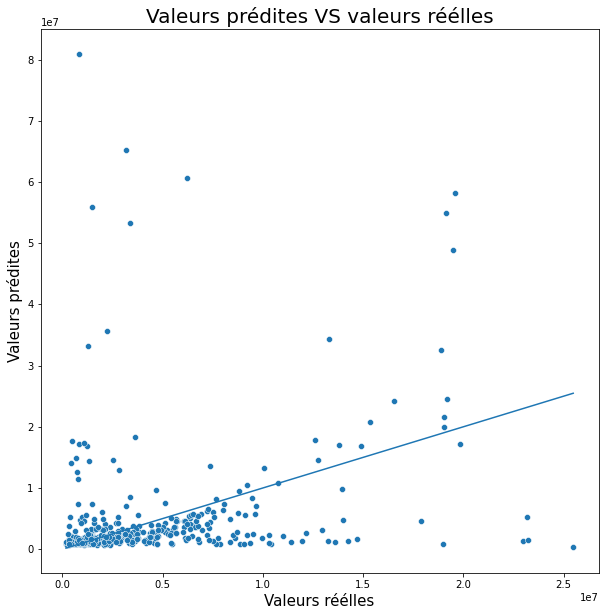

In [39]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_testWithoutOutlier), y = np.exp(y_predWithoutOutlier))
plt.plot([np.exp(y_testWithoutOutlier).min(), np.exp(y_testWithoutOutlier).max()], [np.exp(y_testWithoutOutlier).min(), np.exp(y_testWithoutOutlier).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

Nous pouvons voir que le modèle est moins étiré mais cela ne change rien à notre problème, la relation entre les vraies valeurs et les valeurs prédites n'est pas linéaire.

### Ridge Regressor

Nous allons chercher dans un premier les meilleurs hyperparamètres:

class (alpha=1.0, *, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=Nonesklearn.linear_model.Ridge)

In [40]:
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              'fit_intercept' : [True, False],
              'normalize' : [True, False]
             }

gs_ridgeRegressor = GridSearchCV(estimator = Ridge(), 
                  param_grid = parameters,
                  scoring = score,
                  verbose = 2,
                  cv = cv_train,                                                        
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1            
                  )

gs_ridgeRegressor.fit(X_train, y_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [41]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_ridgeRegressor.best_params_)

scores = cross_val_score(gs_ridgeRegressor, X_train, y_train, cv = cv_train)
cv_results = cross_validate(gs_ridgeRegressor, X_train, y_train, cv = cv_train)

Nous avons les meilleurs résultats avec les paramètres: 
 {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits


In [42]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(gs_ridgeRegressor.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        gs_ridgeRegressor.cv_results_['mean_test_neg_mean_absolute_error'], # score moyen
        gs_ridgeRegressor.cv_results_['std_test_neg_mean_absolute_error'],  # écart-type du score
        gs_ridgeRegressor.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}
Résultats de la validation croisée :
('r2', 'neg_mean_absolute_error') = -0.399 (+/-0.027) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'auto'}
('r2', 'neg_mean_absolute_error') = -0.399 (+/-0.027) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}
('r2', 'neg_mean_absolute_error') = -0.399 (+/-0.027) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'cholesky'}
('r2', 'neg_mean_absolute_error') = -0.399 (+/-0.027) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}
('r2', 'neg_mean_absolute_error') = -0.399 (+/-0.027) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'sparse_cg'}
('r2', 'neg_mean_absolute_error') = -0.399 (+/-0.027) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}
('r2'

In [43]:
print("MSE : ", mean_squared_error(y_test, gs_ridgeRegressor.predict(X_test))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test, gs_ridgeRegressor.predict(X_test))))

y_pred = gs_ridgeRegressor.predict(X_test)

print("MAE Train: ", mae(y_train, gs_ridgeRegressor.predict(X_train)))
print("MAE Test: ", mae(y_test, gs_ridgeRegressor.predict(X_test)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test), np.exp(gs_ridgeRegressor.predict(X_test)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test), np.exp(gs_ridgeRegressor.predict(X_test)))))
print("MAE Train réelle: ", mae(np.exp(y_train), np.exp(gs_ridgeRegressor.predict(X_train))))
print("MAE Test réelle: ", mae(np.exp(y_test), np.exp(gs_ridgeRegressor.predict(X_test))))

MSE :  0.28557778634247777
RMSE :  0.5343947851003766
MAE Train:  0.39584779249779106
MAE Test:  0.4253423607324083 

"Erreur réelle: "

MSE réelle:  172137651474284.44
RMSE réelle:  13120123.912306791
MAE Train réelle:  2403318.3717004894
MAE Test réelle:  3007677.482304189


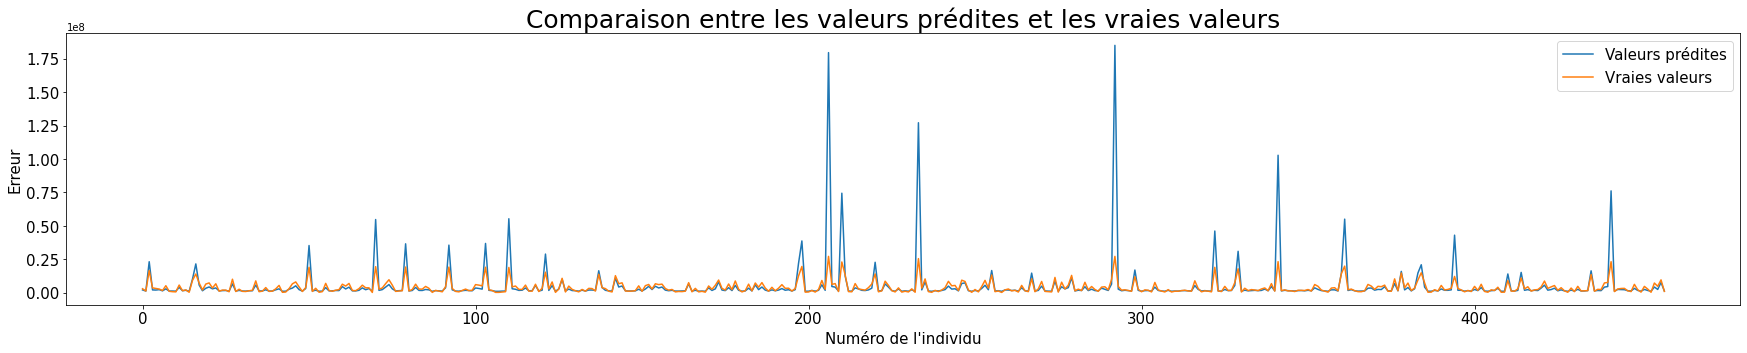

In [44]:
fig = plt.figure(figsize = (30, 5))
plt.title('Comparaison entre les valeurs prédites et les vraies valeurs', fontsize = 25)
plt.plot(np.exp(list(y_pred)))
plt.plot(np.exp(list(y_test)))
plt.legend(["Valeurs prédites", "Vraies valeurs"], loc = "upper right", fontsize = 15)
plt.xlabel('Numéro de l\'individu', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

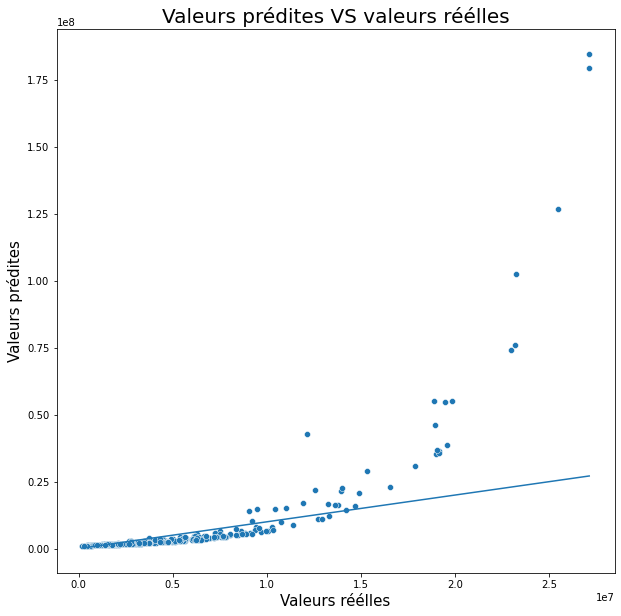

In [45]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_test), y = np.exp(y_pred))
plt.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

Comme nous pouvons nous y attendre et comme nous pouvons le voir, nous obtenons le même comportement qu'avec la regression linéaire, nous allons procéder de la même manière que pour la régression linéaire mais il y a fort à parier que nous aurons quasiment la même chose.

In [46]:
y_testWithoutOutlier = y_test.copy()
np.exp(y_testWithoutOutlier).sort_values()

425      178243.0
168      183521.0
494      226375.0
669      230365.0
367      231964.0
          ...    
109    23179128.0
254    23230284.0
987    25478086.0
988    27137190.0
427    27139746.0
Name: SiteEnergyUse(kBtu)_Standardiser, Length: 458, dtype: float64

In [47]:
del y_testWithoutOutlier[988]

In [48]:
del y_testWithoutOutlier[427]

In [49]:
np.exp(y_testWithoutOutlier).sort_values()

425      178243.0
168      183521.0
494      226375.0
669      230365.0
367      231964.0
          ...    
113    19854012.0
231    22965152.0
109    23179128.0
254    23230284.0
987    25478086.0
Name: SiteEnergyUse(kBtu)_Standardiser, Length: 456, dtype: float64

In [50]:
y_predWithoutOutlier = y_pred.copy()
valeurASupprimer = np.exp(y_predWithoutOutlier).max()

for i in range(y_pred.shape[0]):
    if np.exp(y_pred)[i] == np.exp(y_predWithoutOutlier).max():
        y_predWithoutOutlier = np.delete(y_predWithoutOutlier, i)

In [51]:
for i in range(y_pred.shape[0]):
    if np.exp(y_pred)[i] == np.exp(y_predWithoutOutlier).max():
        y_predWithoutOutlier = np.delete(y_predWithoutOutlier, i)
        break

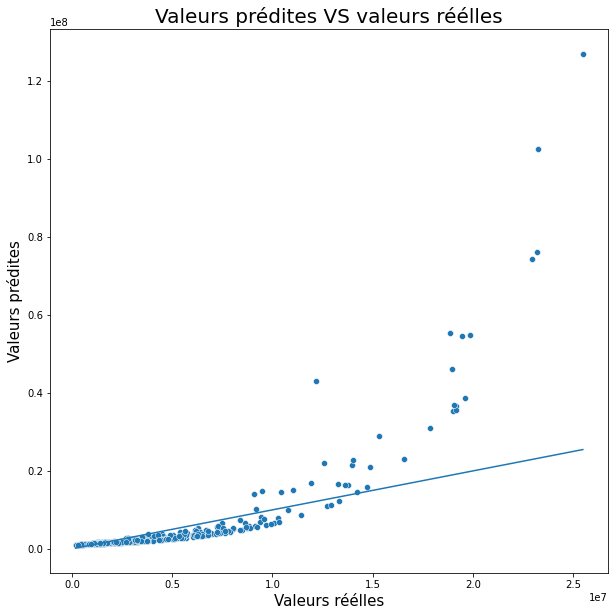

In [52]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_testWithoutOutlier), y = np.exp(y_predWithoutOutlier))
plt.plot([np.exp(y_test).min(), np.exp(y_testWithoutOutlier).max()], [np.exp(y_testWithoutOutlier).min(), np.exp(y_testWithoutOutlier).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

Comme c'était le cas pour la régression linéaire, le nuage de point et moins étiré mais la relation entre les vraies valeurs et les valeurs prédites n'est toujours pas linéaire.

### Random Forest Regressor

Nous allons chercher dans un premier les meilleurs hyperparamètres:

class (n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0,0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0,0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=Aucun, détaillé=0, warm_start=Faux, ccp_alpha=0,0, max_samples=Aucun sklearn.ensemble.RandomForestRegressor)

Après plusieurs test nous avons les meilleurs résultats avec les hyperparamètres suivant, nous avons testé l'hyperparamètre max_depth mais nous avions les meilleurs résultats pour la valeur None, donc pour une question de temps nous avons retiré ce paramètre:

{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200} (meilleurs paramètres pour plusieurs test, pour une question de temps nous n'allons garder que quelques paramètres et non tous)

In [53]:
param_rfr = {'n_estimators' : [800, 1200],
             'max_depth' : [15, 30, None],            
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 5]}

gs_randomForestRegression = GridSearchCV(RandomForestRegressor(),
                 param_grid = param_rfr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,                  
                  n_jobs = -1
                 )


gs_randomForestRegression.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [15, 30, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [800, 1200]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [54]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_randomForestRegression.best_params_)

Nous avons les meilleurs résultats avec les paramètres: 
 {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}


In [139]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_randomForestRegression.best_params_)
rf = RandomForestRegressor(max_depth = 15, max_features = 'auto', n_estimators = 1200, min_samples_leaf = 1, min_samples_split = 2)
scores = cross_val_score(rf, X_train, y_train, cv = cv_train)
scoresTest = cross_val_score(rf, X_test, y_test, cv = cv_train)
cv_results = cross_validate(rf, X_train, y_train, cv = cv_train)
cv_results_test = cross_validate(rf, X_test, y_test, cv = cv_train)

Nous avons les meilleurs résultats avec les paramètres: 
 {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}


In [140]:
cv_results

{'fit_time': array([7.75614452, 7.28256416, 8.39751959, 7.88644385, 8.15966773]),
 'score_time': array([0.30553293, 0.30602217, 0.30802274, 0.37402987, 0.30154419]),
 'test_score': array([0.9964342 , 0.99177627, 0.98130348, 0.97745805, 0.99308995])}

In [141]:
cv_results_test

{'fit_time': array([5.42142272, 5.30642343, 5.39624643, 5.30441427, 5.22840738]),
 'score_time': array([0.23401856, 0.27202034, 0.2850225 , 0.25501966, 0.25601912]),
 'test_score': array([0.98991193, 0.99489676, 0.98771593, 0.99471387, 0.98235947])}

Text(0.5, 1.0, 'Score de crossValidation sur le jeu de test')

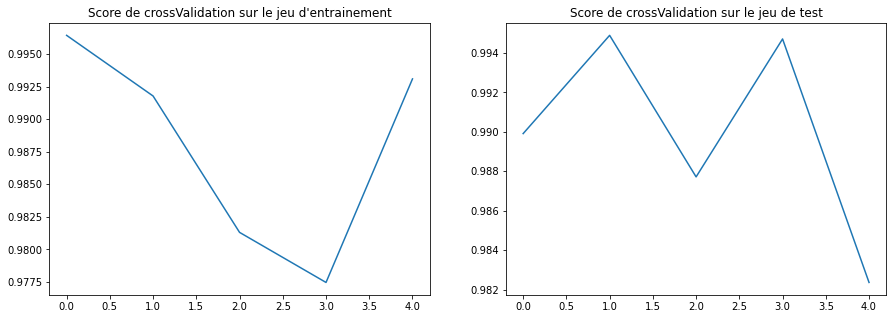

In [142]:
fig = plt.figure(figsize = (15, 5))

listeResults = cv_results['test_score'].tolist()
listeResultsTest = cv_results_test['test_score'].tolist()

plt.subplot(1, 2, 1)
plt.plot(listeResults)
plt.title('Score de crossValidation sur le jeu d\'entrainement')

plt.subplot(1, 2, 2)
plt.plot(listeResultsTest)
plt.title('Score de crossValidation sur le jeu de test')

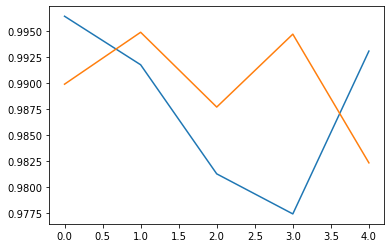

In [143]:
plt.plot(listeResults)
plt.plot(listeResultsTest)

In [144]:
gs_randomForestRegression.cv_results_

{'mean_fit_time': array([3.52197385, 5.23684893, 3.0081409 , 4.56824107, 3.08623323,
        4.76686144, 3.00002189, 4.42852917, 3.12386575, 4.750774  ,
        2.88573608, 4.05014911, 2.67241912, 4.01989932, 2.75280485,
        4.00209727, 3.15135207, 4.60465989, 2.89162683, 4.21642375,
        2.76840973, 4.28531885, 2.80021973, 4.30182219, 3.60447435,
        5.31411934, 3.22566595, 4.81830688, 3.19845686, 4.84447384,
        3.1227345 , 4.55374784, 2.97802615, 4.6050859 , 2.83973994,
        4.09561343, 2.75342793, 4.17922297, 2.86041713, 4.00260901,
        3.15865932, 4.73300667, 2.88324175, 4.15903358, 2.77402139,
        3.99390244, 2.69891868, 4.21703863, 3.7201128 , 5.33824043,
        3.23145318, 4.85267572, 3.20674109, 4.78475518, 3.12834129,
        4.79928675, 3.08654919, 4.70369101, 2.86345482, 4.36193514,
        2.76055198, 3.97129517, 2.72580786, 3.9867218 , 3.31557193,
        4.97900596, 2.80551729, 4.15971489, 2.79781322, 4.1252131 ,
        2.69140892, 3.62248931]

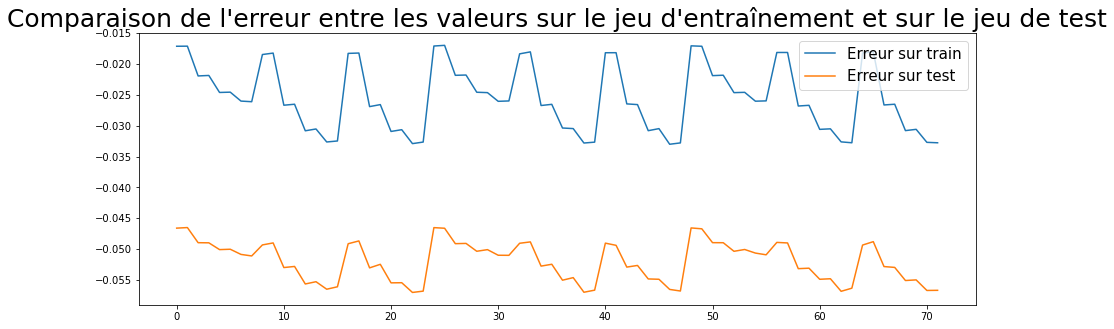

In [145]:
listeTrainNeg = gs_randomForestRegression.cv_results_['mean_train_neg_mean_absolute_error']
listeTestNeg = gs_randomForestRegression.cv_results_['mean_test_neg_mean_absolute_error']

MeanTrainNeg = gs_randomForestRegression.cv_results_['mean_train_neg_mean_absolute_error'].mean()
MeanTestNeg = gs_randomForestRegression.cv_results_['mean_test_neg_mean_absolute_error'].mean()

fig = plt.figure(figsize = (15, 5))
plt.title('Comparaison de l\'erreur entre les valeurs sur le jeu d\'entraînement et sur le jeu de test', fontsize = 25)
plt.plot(listeTrainNeg)
plt.plot(listeTestNeg)
plt.legend(["Erreur sur train", "Erreur sur test"], loc = "upper right", fontsize = 15)

In [146]:
rf = RandomForestRegressor(n_estimators = 50)
listeMSETrain = []
listeMSETest = []
for iter in range(24):
    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_predicted)
    mse_test = mean_squared_error(y_test, y_test_predicted)
    #print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    listeMSETrain.append(mse_train)
    listeMSETest.append(mse_test)
    rf.n_estimators += 50

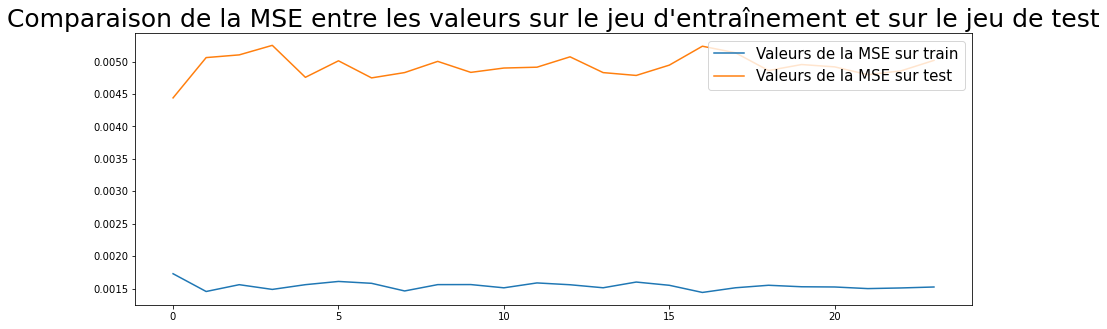

In [147]:
fig = plt.figure(figsize = (15, 5))
plt.title('Comparaison de la MSE entre les valeurs sur le jeu d\'entraînement et sur le jeu de test', fontsize = 25)
plt.plot(listeMSETrain)
plt.plot(listeMSETest)
plt.legend(["Valeurs de la MSE sur train", "Valeurs de la MSE sur test"], loc = "upper right", fontsize = 15)

Nous pouvons voir un surapprentissage à partir d'un certains seuil, il faudra donc bien faire attention aux valeurs que l'on prendra pour nos hyperparamètres.

In [148]:
rf = RandomForestRegressor(max_depth = 1)
listeMSETrain_maxdepth= []
listeMSETest_maxdepth = []
for iter in range(16):
    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_predicted)
    mse_test = mean_squared_error(y_test, y_test_predicted)
    #print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
    listeMSETrain_maxdepth.append(mse_train)
    listeMSETest_maxdepth.append(mse_test)
    rf.max_depth += 1

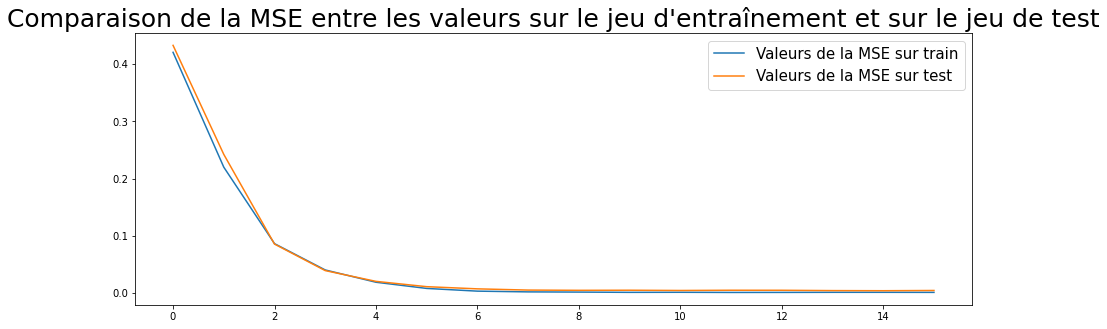

In [149]:
fig = plt.figure(figsize = (15, 5))
plt.title('Comparaison de la MSE entre les valeurs sur le jeu d\'entraînement et sur le jeu de test', fontsize = 25)
plt.plot(listeMSETrain_maxdepth)
plt.plot(listeMSETest_maxdepth)
plt.legend(["Valeurs de la MSE sur train", "Valeurs de la MSE sur test"], loc = "upper right", fontsize = 15)

In [150]:
rf = RandomForestRegressor(max_depth = 1, n_estimators = 50, max_features = 'auto')
listeMSETrain_all= []
listeMSETest_all = []
listeRMSETrain_all= []
listeRMSETest_all = []
listeFeature = ['auto', 'sqrt', 'log2']
for i in range(5): #16 à la place de 5 
    for j in range(1, 5): #16 à la place de 5
        rf.max_depth = j
        for features in listeFeature:    
            rf.fit(X_train, y_train)
            y_pred_train = rf.predict(X_train)
            y_pred_test = rf.predict(X_test)
            mse_train = mean_squared_error(y_train, y_pred_train)
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_train = math.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
            rmse_test = math.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
            #print("Iteration: {} Train mse: {} Test mse: {}".format(iter, mse_train, mse_test))
            listeMSETrain_all.append(mse_train)
            listeMSETest_all.append(mse_test)
            listeRMSETrain_all.append(mse_train)
            listeRMSETest_all.append(mse_test)
            #print('feature, max_depth, n_estimators: ', features, rf.max_depth, rf.n_estimators)
            print("RMSE Train = {:.5f}, MSE Train = {:.05f}  for(max_feature = {}, max_depth = {} et n_estimators = {})".format(rmse_train, mse_train, features,  rf.max_depth, rf.n_estimators)) 
            print("RMSE Test = {:.5f}, MSE Test = {:.05f}  for(max_feature = {}, max_depth = {} et n_estimators = {})".format(rmse_test, mse_test, features,  rf.max_depth, rf.n_estimators), '\n') 
        
    rf.n_estimators += 100

RMSE Train = 0.65369, MSE Train = 0.42732  for(max_feature = auto, max_depth = 1 et n_estimators = 50)
RMSE Test = 0.66227, MSE Test = 0.43860  for(max_feature = auto, max_depth = 1 et n_estimators = 50) 

RMSE Train = 0.64939, MSE Train = 0.42171  for(max_feature = sqrt, max_depth = 1 et n_estimators = 50)
RMSE Test = 0.65792, MSE Test = 0.43286  for(max_feature = sqrt, max_depth = 1 et n_estimators = 50) 

RMSE Train = 0.64687, MSE Train = 0.41844  for(max_feature = log2, max_depth = 1 et n_estimators = 50)
RMSE Test = 0.65558, MSE Test = 0.42979  for(max_feature = log2, max_depth = 1 et n_estimators = 50) 

RMSE Train = 0.46595, MSE Train = 0.21711  for(max_feature = auto, max_depth = 2 et n_estimators = 50)
RMSE Test = 0.48778, MSE Test = 0.23793  for(max_feature = auto, max_depth = 2 et n_estimators = 50) 

RMSE Train = 0.47539, MSE Train = 0.22600  for(max_feature = sqrt, max_depth = 2 et n_estimators = 50)
RMSE Test = 0.49840, MSE Test = 0.24841  for(max_feature = sqrt, max_dept

RMSE Train = 0.46971, MSE Train = 0.22063  for(max_feature = sqrt, max_depth = 2 et n_estimators = 350)
RMSE Test = 0.49171, MSE Test = 0.24178  for(max_feature = sqrt, max_depth = 2 et n_estimators = 350) 

RMSE Train = 0.47581, MSE Train = 0.22640  for(max_feature = log2, max_depth = 2 et n_estimators = 350)
RMSE Test = 0.49901, MSE Test = 0.24901  for(max_feature = log2, max_depth = 2 et n_estimators = 350) 

RMSE Train = 0.29816, MSE Train = 0.08890  for(max_feature = auto, max_depth = 3 et n_estimators = 350)
RMSE Test = 0.29835, MSE Test = 0.08901  for(max_feature = auto, max_depth = 3 et n_estimators = 350) 

RMSE Train = 0.30207, MSE Train = 0.09124  for(max_feature = sqrt, max_depth = 3 et n_estimators = 350)
RMSE Test = 0.30301, MSE Test = 0.09182  for(max_feature = sqrt, max_depth = 3 et n_estimators = 350) 

RMSE Train = 0.30153, MSE Train = 0.09092  for(max_feature = log2, max_depth = 3 et n_estimators = 350)
RMSE Test = 0.30169, MSE Test = 0.09101  for(max_feature = log2,

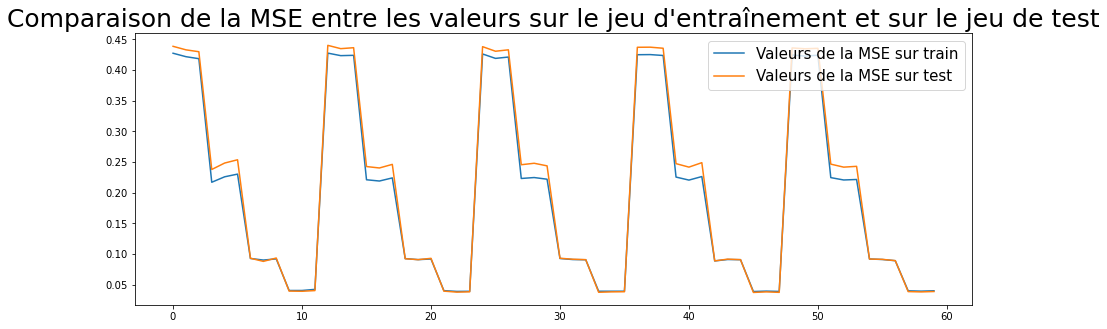

In [151]:
fig = plt.figure(figsize = (15, 5))
plt.title('Comparaison de la MSE entre les valeurs sur le jeu d\'entraînement et sur le jeu de test', fontsize = 25)
plt.plot(listeMSETrain_all)
plt.plot(listeMSETest_all)
plt.legend(["Valeurs de la MSE sur train", "Valeurs de la MSE sur test"], loc = "upper right", fontsize = 15)

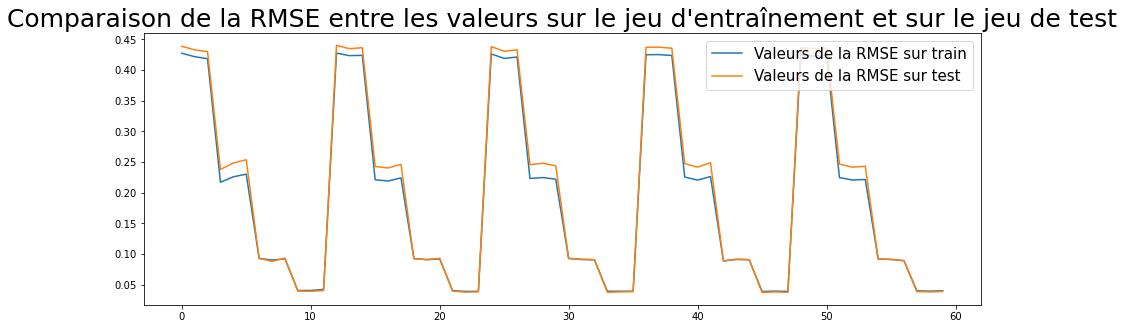

In [152]:
fig = plt.figure(figsize = (15, 5))
plt.title('Comparaison de la RMSE entre les valeurs sur le jeu d\'entraînement et sur le jeu de test', fontsize = 25)
plt.plot(listeRMSETrain_all)
plt.plot(listeRMSETest_all)
plt.legend(["Valeurs de la RMSE sur train", "Valeurs de la RMSE sur test"], loc = "upper right", fontsize = 15)

Il n'y a pas de trace d'un éventuel surapprentissage, notre modèle est correct pour la suite.

In [153]:
listeAccuracyTest = []
listeAccuracyTrain = []

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(gs_randomForestRegression.best_params_, '\n')

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for meantrain, stdtrain, meantest, stdtest, params, mean_fit_time, mean_score_time in zip(
        gs_randomForestRegression.cv_results_['mean_train_neg_mean_absolute_error'], # score moyen        
        gs_randomForestRegression.cv_results_['std_train_neg_mean_absolute_error'],  # écart-type du score
        gs_randomForestRegression.cv_results_['mean_test_neg_mean_absolute_error'], # score moyen        
        gs_randomForestRegression.cv_results_['std_test_neg_mean_absolute_error'],  # écart-type du score    
        gs_randomForestRegression.cv_results_['params'],           # valeur de l'hyperparamètre
        gs_randomForestRegression.cv_results_['mean_fit_time'],
        gs_randomForestRegression.cv_results_['std_fit_time']
    ):

    
    print("{} = train: {:.3f} (+/-{:.03f}), test: {:.3f} (+/-{:.03f})  for {}, mean fit time: {:.5f}, mean score time: {:.5f}".format(
        score,
        meantrain,
        stdtrain*2,
        meantest,
        stdtest*2,
        params,
        mean_fit_time,
        mean_score_time
    ), '\n')
    listeAccuracyTest.append(meantest)   
    listeAccuracyTrain.append(meantrain)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200} 

Résultats de la validation croisée :
('r2', 'neg_mean_absolute_error') = train: -0.017 (+/-0.001), test: -0.047 (+/-0.011)  for {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}, mean fit time: 3.52197, mean score time: 0.02766 

('r2', 'neg_mean_absolute_error') = train: -0.017 (+/-0.001), test: -0.047 (+/-0.011)  for {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}, mean fit time: 5.23685, mean score time: 0.06224 

('r2', 'neg_mean_absolute_error') = train: -0.022 (+/-0.001), test: -0.049 (+/-0.010)  for {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}, mean fit time: 3.00814, mean score time: 0.03866 

('r2', 'neg_mean_absolute_error')

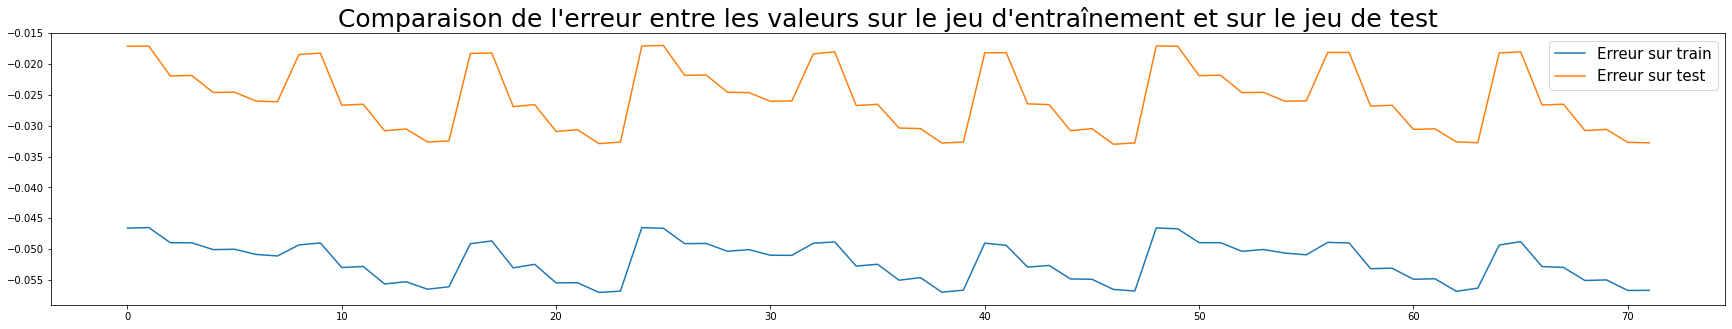

In [154]:
fig = plt.figure(figsize = (30, 5))
plt.title('Comparaison de l\'erreur entre les valeurs sur le jeu d\'entraînement et sur le jeu de test', fontsize = 25)
plt.plot(listeAccuracyTest)
plt.plot(listeAccuracyTrain)
plt.legend(["Erreur sur train", "Erreur sur test"], loc = "upper right", fontsize = 15)

In [155]:
accuracy = gs_randomForestRegression.score(X_train, y_train)
print(accuracy)

accuracy = gs_randomForestRegression.score(X_test, y_test)
print(accuracy)

-0.01549916485060358
-0.036627623829222106


In [156]:
print("MSE : ", mean_squared_error(y_test, gs_randomForestRegression.predict(X_test))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test, gs_randomForestRegression.predict(X_test))))

y_pred = gs_randomForestRegression.predict(X_test)

print("MAE Train: ", mae(y_train, gs_randomForestRegression.predict(X_train)))
print("MAE Test: ", mae(y_test, gs_randomForestRegression.predict(X_test)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test), np.exp(gs_randomForestRegression.predict(X_test)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test), np.exp(gs_randomForestRegression.predict(X_test)))))
print("MAE Train réelle: ", mae(np.exp(y_train), np.exp(gs_randomForestRegression.predict(X_train))))
print("MAE Test réelle: ", mae(np.exp(y_test), np.exp(gs_randomForestRegression.predict(X_test))))

MSE :  0.0048962525605389905
RMSE :  0.06997322745549894
MAE Train:  0.01549916485060358
MAE Test:  0.036627623829222106 

"Erreur réelle: "

MSE réelle:  189252645113.67548
RMSE réelle:  435031.7748322247
MAE Train réelle:  69496.46154344035
MAE Test réelle:  161339.5313799412


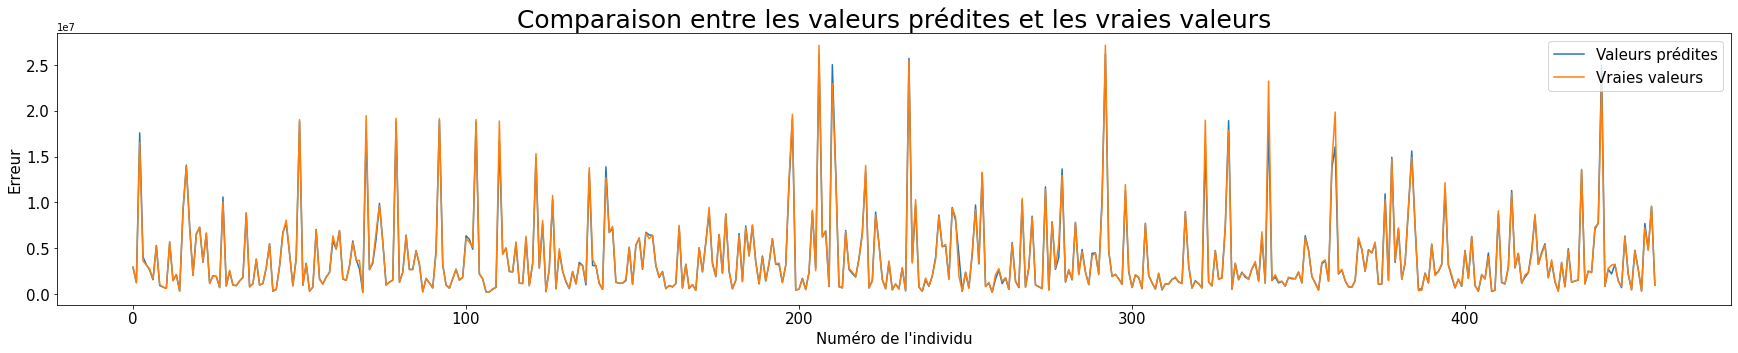

In [73]:
fig = plt.figure(figsize = (30, 5))
plt.title('Comparaison entre les valeurs prédites et les vraies valeurs', fontsize = 25)
plt.plot(np.exp(list(y_pred)))
plt.plot(np.exp(list(y_test)))
plt.legend(["Valeurs prédites", "Vraies valeurs"], loc = "upper right", fontsize = 15)
plt.xlabel('Numéro de l\'individu', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

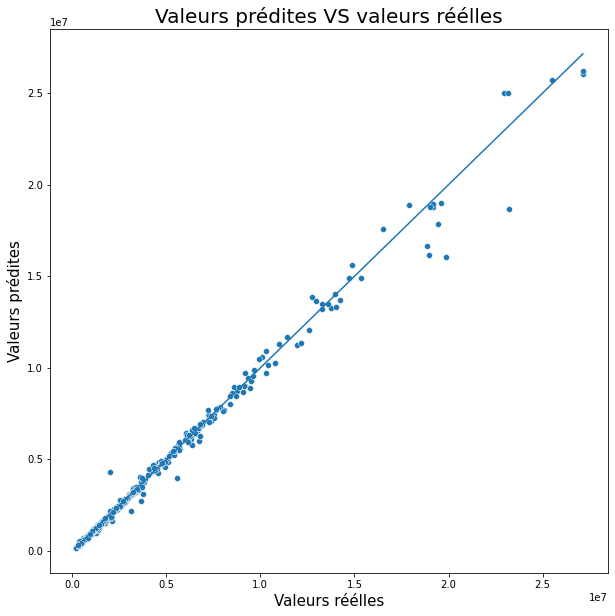

In [74]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_test), y = np.exp(y_pred))
plt.plot([np.exp(y_test).min(), np.exp(y_test).max()], [np.exp(y_test).min(), np.exp(y_test).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

### Comparaison des différents modèles

Nous avons tester différents modèle de regressions, comparons les afin de voir lequel correspond le mieux à ce que nous souhaitons, c'est à dire, prédire au mieux les valeurs de SiteEnergyUse:

In [75]:
print('Linear Regression: ')
print('Fit time:', gs_linearRegression_OnlyEnergy.cv_results_['mean_fit_time'].mean())
print('Predict time:', gs_linearRegression_OnlyEnergy.cv_results_['mean_score_time'].mean())
print("MSE : ", mean_squared_error(y_test_OnlyEnergy, gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy)))
print("RMSE : ", math.sqrt(mean_squared_error(y_test_OnlyEnergy, gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy))), '\n')

print('Ridge Regressor: ')
print('Fit time:', gs_ridgeRegressor.cv_results_['mean_fit_time'].mean())
print('Predict time:', gs_ridgeRegressor.cv_results_['mean_score_time'].mean())
print("MSE : ", mean_squared_error(y_test, gs_ridgeRegressor.predict(X_test)))
print("RMSE : ", math.sqrt(mean_squared_error(y_test, gs_ridgeRegressor.predict(X_test))), '\n')

print('Random Forest Regression: ')
print('Fit time:', gs_randomForestRegression.cv_results_['mean_fit_time'].mean())
print('Predict time:', gs_randomForestRegression.cv_results_['mean_score_time'].mean())
print("MSE : ", mean_squared_error(y_test, gs_randomForestRegression.predict(X_test)))
print("RMSE : ", math.sqrt(mean_squared_error(y_test, gs_randomForestRegression.predict(X_test))))

Linear Regression: 
Fit time: 0.006950569152832031
Predict time: 0.004000115394592285
MSE :  0.28558125994290356
RMSE :  0.5343980351226074 

Ridge Regressor: 
Fit time: 0.006925774837026791
Predict time: 0.004605636548022835
MSE :  0.28557778634247777
RMSE :  0.5343947851003766 

Random Forest Regression: 
Fit time: 3.7295377989610037
Predict time: 0.17866194248199463
MSE :  0.0048962525605389905
RMSE :  0.06997322745549894


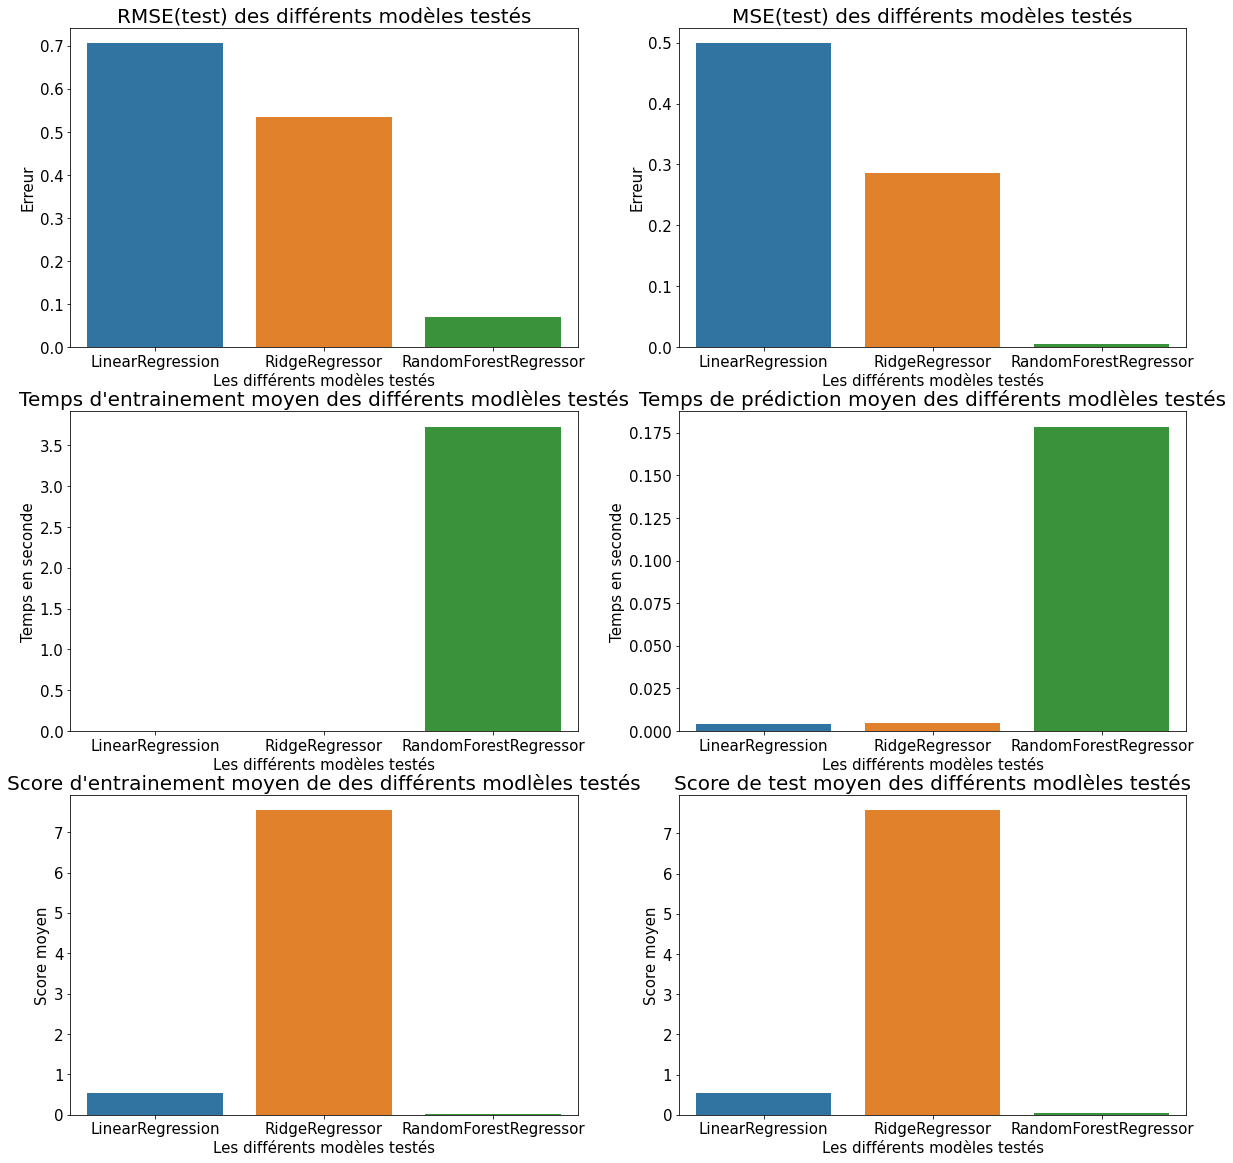

In [157]:
fig = plt.figure(figsize = (20, 20))

listeModeles = ['LinearRegression', 'RidgeRegressor', 'RandomForestRegressor']
listeRMSE = [math.sqrt(mean_squared_error(y_test_OnlyEnergy, gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy))), math.sqrt(mean_squared_error(y_test, gs_ridgeRegressor.predict(X_test))), math.sqrt(mean_squared_error(y_test, gs_randomForestRegression.predict(X_test)))]
listeMSE = [mean_squared_error(y_test_OnlyEnergy, gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy)), mean_squared_error(y_test, gs_ridgeRegressor.predict(X_test)), mean_squared_error(y_test, gs_randomForestRegression.predict(X_test))]
listeFitTime = [gs_linearRegression_OnlyEnergy.cv_results_['mean_fit_time'].mean(), gs_ridgeRegressor.cv_results_['mean_fit_time'].mean(), gs_randomForestRegression.cv_results_['mean_fit_time'].mean()]
listePredictTime = [gs_linearRegression_OnlyEnergy.cv_results_['mean_score_time'].mean(), gs_ridgeRegressor.cv_results_['mean_score_time'].mean(), gs_randomForestRegression.cv_results_['mean_score_time'].mean()]
listeMeanTrain = [-1*gs_linearRegression_OnlyEnergy.cv_results_['mean_train_neg_mean_absolute_error'].mean(), -1*gs_ridgeRegressor.cv_results_['mean_train_neg_mean_absolute_error'].mean(), -1*gs_randomForestRegression.cv_results_['mean_train_neg_mean_absolute_error'].mean()]
listeMeanTest = [-1*gs_linearRegression_OnlyEnergy.cv_results_['mean_test_neg_mean_absolute_error'].mean(), -1*gs_ridgeRegressor.cv_results_['mean_test_neg_mean_absolute_error'].mean(), -1*gs_randomForestRegression.cv_results_['mean_test_neg_mean_absolute_error'].mean()]

plt.subplot(3,2,1)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,2)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Temps en seconde', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,4)
sns.barplot(x = listeModeles, y = listePredictTime)
plt.title('Temps de prédiction moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Temps en seconde', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,5)
sns.barplot(x = listeModeles, y = listeMeanTrain)
plt.title('Score d\'entrainement moyen de des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Score moyen', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,6)
sns.barplot(x = listeModeles, y = listeMeanTest)
plt.title('Score de test moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Score moyen', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

Nous avons testé 2  modèles de régressions qui améliorent le RMSE de la baseline, soit de manière importante pour le modéle Random Forest, soit de manière vraiment minime pour le modèle Ridge.
    
Bien que Random Forest soit plus long que l'autre, c'est celui qui offre le meilleur RMSE et MSE, nous allons donc opter pour ce dernier.
Si Ridge avait eu un RMSE un peu moins bon pour le même temps, nous aurions pu opter pour celui là, car même s'il est moins bon, nous serions gagnant en terme de temps, mais là il est plus intéressant de perdre du temps à ce niveau selon moi.

# Prédiction émissions de CO2

Nous allons procéder de la même manière que pour SiteEnergyUse, nous allons commencer par un modèle simple et nous finirons par un modème plus complexe, mais avant ça nous allons regarder l'impact des variables:

In [77]:
X_TotalGHGEmissions_train, X_TotalGHGEmissions_test, y_TotalGHGEmissions_train, y_TotalGHGEmissions_test = train_test_split(X, y['totalGHGEmissions_Standardisation'], test_size = 0.3, random_state = 42)

### Baseline

In [78]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_TotalGHGEmissions = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )


gs_linearRegression_TotalGHGEmissions.fit(X_TotalGHGEmissions_train, y_TotalGHGEmissions_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [79]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_linearRegression_TotalGHGEmissions.best_params_)

Nous avons les meilleurs résultats avec les paramètres: 
 {'fit_intercept': 'True', 'normalize': 'True'}


In [80]:
print("MSE : ", mean_squared_error(y_TotalGHGEmissions_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_TotalGHGEmissions_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))))

y_TotalGHGEmissions_pred = gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)

print("MAE Train: ", mae(y_TotalGHGEmissions_train, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_train)))
print("MAE Test: ", mae(y_TotalGHGEmissions_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_TotalGHGEmissions_test), np.exp(gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_TotalGHGEmissions_test), np.exp(gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))))
print("MAE Train réelle: ", mae(np.exp(y_TotalGHGEmissions_train), np.exp(gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_train))))
print("MAE Test réelle: ", mae(np.exp(y_TotalGHGEmissions_test), np.exp(gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))))

MSE :  0.4438260161649993
RMSE :  0.6662026839971446
MAE Train:  0.47975159768770187
MAE Test:  0.5070223799844472 

"Erreur réelle: "

MSE réelle:  7612951.696343835
RMSE réelle:  2759.157787503976
MAE Train réelle:  52.911599987223326
MAE Test réelle:  179.0204741330358


In [81]:
XTest = X.copy()
XTest.drop(['Electricity(kBtu)','NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'SteamUse(kBtu)'], axis = 1, inplace = True)

In [82]:
X_train_withoutEnergy, X_test_withoutEnergy, y_train_withoutEnergy, y_test_withoutEnergy = train_test_split(XTest, y['totalGHGEmissions_Standardisation'], test_size = 0.3, random_state = 42)

In [83]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_withoutEnergy = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )


gs_linearRegression_withoutEnergy.fit(X_train_withoutEnergy, y_train_withoutEnergy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [84]:
y_pred_withoutEnergy = gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy)

print("MSE : ", mean_squared_error(y_test_withoutEnergy, gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test_withoutEnergy, gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy))), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test_withoutEnergy), np.exp(gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test_withoutEnergy), np.exp(gs_linearRegression_withoutEnergy.predict(X_test_withoutEnergy)))))

MSE :  1.016791150310522
RMSE :  1.0083606251289874 

"Erreur réelle: "

MSE réelle:  10193.131739785751
RMSE réelle:  100.96104070276688


In [85]:
XTest = X.copy()
XTest.drop(['x0_2', 'x0_3', 'x0_4', 'x2_5', 'x1_5', 'x1_4', 'x2_4', 'x2_1', 'x2_2', 'x2_6', 'x2_3', 'x1_1', 'x1_3', 'x1_2'], axis = 1, inplace = True)

In [86]:
X_train_withoutF, X_test_withoutF, y_train_withoutF, y_test_withoutF = train_test_split(XTest, y['totalGHGEmissions_Standardisation'], test_size = 0.3, random_state = 42)

In [87]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_withoutF = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )


gs_linearRegression_withoutF.fit(X_train_withoutF, y_train_withoutF)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [88]:
y_pred_withoutF = gs_linearRegression_withoutF.predict(X_test_withoutF)

print("MSE : ", mean_squared_error(y_test_withoutF, gs_linearRegression_withoutF.predict(X_test_withoutF))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test_withoutF, gs_linearRegression_withoutF.predict(X_test_withoutF))), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test_withoutF), np.exp(gs_linearRegression_withoutF.predict(X_test_withoutF)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test_withoutF), np.exp(gs_linearRegression_withoutF.predict(X_test_withoutF)))))

MSE :  0.4753808606214266
RMSE :  0.6894786875759298 

"Erreur réelle: "

MSE réelle:  7873838.688397984
RMSE réelle:  2806.0361167308565


In [89]:
XTest = X.copy()
XTest.drop(['Electricity(kBtu)','NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'SteamUse(kBtu)', 'x0_2', 'x0_3', 'x0_4', 'x2_5', 'x1_5', 'x1_4', 'x2_4', 'x2_1', 'x2_2', 'x2_6', 'x2_3', 'x1_1', 'x1_3', 'x1_2'], axis = 1, inplace = True)

In [90]:
X_train_withoutEnergyF, X_test_withoutEnergyF, y_train_withoutEnergyF, y_test_withoutEnergyF = train_test_split(XTest, y['totalGHGEmissions_Standardisation'], test_size = 0.3, random_state = 42)

In [91]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_withoutEnergyF = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )


gs_linearRegression_withoutEnergyF.fit(X_train_withoutEnergyF, y_train_withoutEnergyF)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [92]:
y_pred_withoutEnergyF = gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF)

print("MSE : ", mean_squared_error(y_test_withoutEnergyF, gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test_withoutEnergyF, gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF))), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test_withoutEnergyF), np.exp(gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test_withoutEnergyF), np.exp(gs_linearRegression_withoutEnergyF.predict(X_test_withoutEnergyF)))))

MSE :  0.9848457584267667
RMSE :  0.9923939532397236 

"Erreur réelle: "

MSE réelle:  12307.14449293508
RMSE réelle:  110.93757024982601


In [93]:
XTest = X.copy()
XTest.drop(['BuildingType', 'PrimaryPropertyType', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'x0_2', 'x0_3', 'x0_4', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x1_5', 'x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5','x2_6'], axis = 1, inplace = True)

In [94]:
X_train_OnlyEnergy, X_test_OnlyEnergy, y_train_OnlyEnergy, y_test_OnlyEnergy = train_test_split(XTest, y['totalGHGEmissions_Standardisation'], test_size = 0.3, random_state = 42)

In [95]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_OnlyEnergy = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )


gs_linearRegression_OnlyEnergy.fit(X_train_OnlyEnergy, y_train_OnlyEnergy)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [96]:
y_pred_withoutEnergyF = gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy)

print("MSE : ", mean_squared_error(y_test_OnlyEnergy, gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_test_OnlyEnergy, gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy))), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_test_OnlyEnergy), np.exp(gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_test_OnlyEnergy), np.exp(gs_linearRegression_OnlyEnergy.predict(X_test_OnlyEnergy)))))

MSE :  0.49960619259808037
RMSE :  0.706828262449996 

"Erreur réelle: "

MSE réelle:  1771718.561480534
RMSE réelle:  1331.0591878201863


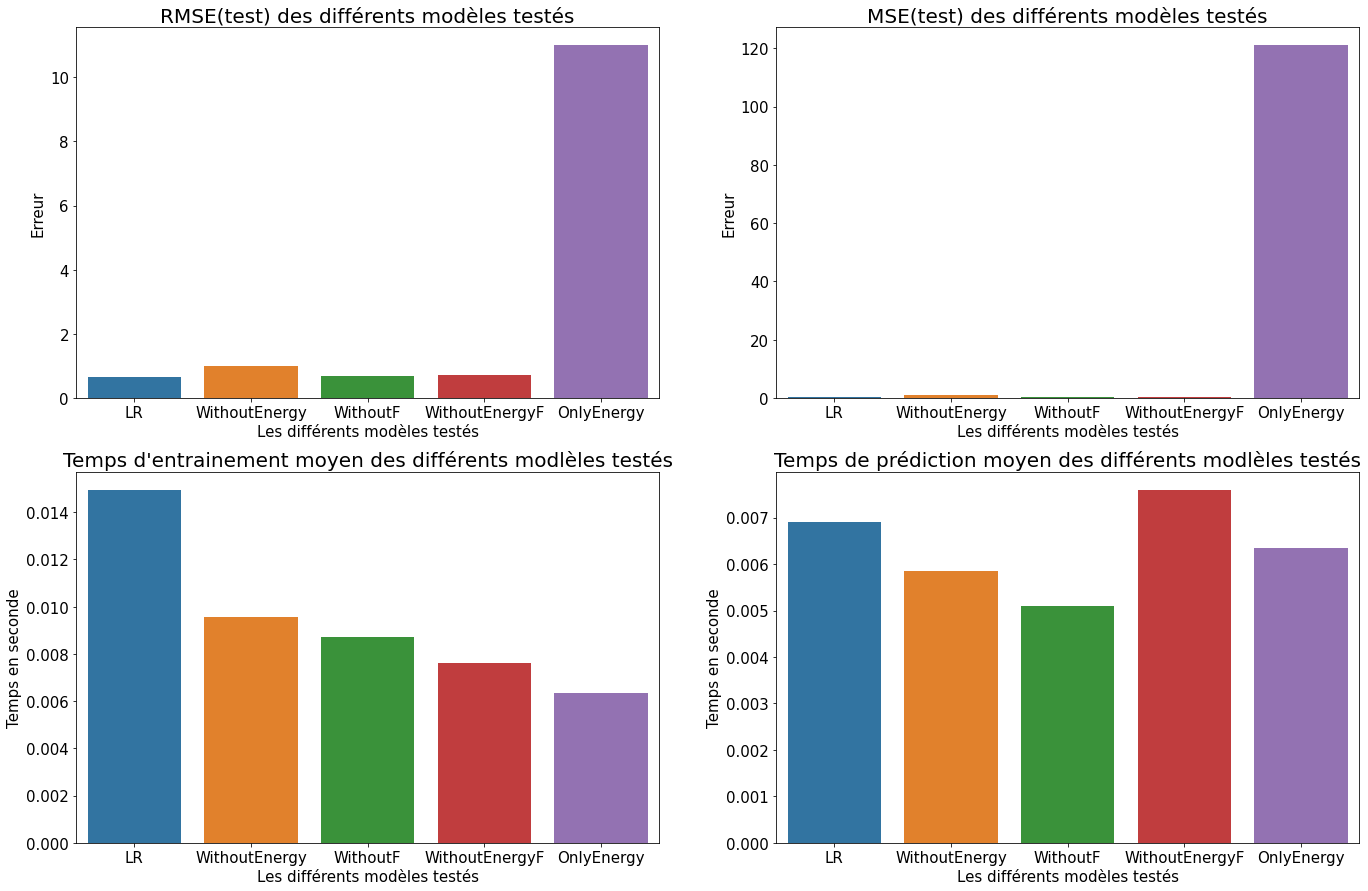

In [97]:
fig = plt.figure(figsize = (23, 15))

listeModeles = ['LR', 'WithoutEnergy', 'WithoutF', 'WithoutEnergyF', 'OnlyEnergy']

listeRMSE = [math.sqrt(mean_squared_error(y_TotalGHGEmissions_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))), math.sqrt(mean_squared_error(y_test_withoutEnergy, y_pred_withoutEnergy)), math.sqrt(mean_squared_error(y_test_withoutF, y_pred_withoutF)), math.sqrt(mean_squared_error(y_test_withoutEnergyF, y_pred_withoutEnergyF)), math.sqrt(mean_squared_error(y_test_OnlyEnergy, y_pred_OnlyEnergy))]
listeMSE = [mean_squared_error(y_TotalGHGEmissions_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)), mean_squared_error(y_test_withoutEnergy, y_pred_withoutEnergy), mean_squared_error(y_test_withoutF, y_pred_withoutF), mean_squared_error(y_test_withoutEnergyF, y_pred_withoutEnergyF), mean_squared_error(y_test_OnlyEnergy, y_pred_OnlyEnergy)]
listeFitTime = [gs_linearRegression_TotalGHGEmissions.cv_results_['mean_fit_time'].mean(), gs_linearRegression_withoutEnergy.cv_results_['mean_fit_time'].mean(), gs_linearRegression_withoutF.cv_results_['mean_fit_time'].mean(), gs_linearRegression_withoutEnergyF.cv_results_['mean_fit_time'].mean(), gs_linearRegression_OnlyEnergy.cv_results_['mean_fit_time'].mean()]
listePredictTime = [gs_linearRegression_TotalGHGEmissions.cv_results_['mean_score_time'].mean(), gs_linearRegression_withoutEnergy.cv_results_['mean_score_time'].mean(), gs_linearRegression_withoutF.cv_results_['mean_score_time'].mean(), gs_linearRegression_withoutEnergyF.cv_results_['mean_fit_time'].mean(), gs_linearRegression_OnlyEnergy.cv_results_['mean_fit_time'].mean()]

plt.subplot(2,2,1)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Temps en seconde', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,4)
sns.barplot(x = listeModeles, y = listePredictTime)
plt.title('Temps de prédiction moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Temps en seconde', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

Contrairement à l'énergie consommée , si on ne garde que les énergies nous aurons le pire RMSE et MSE possible, nous pouvons voir qu'en retirant les différentes énergies du jeu de données,les features créées par OneHotEncoder ou encore toutes ces variables d'un coup, cela ne va pas avoir une grande incidence, cependant en terme de temps de calcul nous y gagnerons en supprimmant les features et les énergies en terme d'entrainement mais pas en terme de prédiction, pour la suite nous garderons toutes les features.

In [98]:
X1 = X.copy()
X_TotalGHGEmissions_train, X_TotalGHGEmissions_test, y_TotalGHGEmissions_train, y_TotalGHGEmissions_test  = train_test_split(X1, y['totalGHGEmissions_Standardisation'], test_size = 0.3, random_state = 42)

In [99]:
param_lr = {'fit_intercept' : ['True', 'False'],          
             'normalize': ['True', 'False']             
            }

gs_linearRegression_TotalGHGEmissions = GridSearchCV(LinearRegression(),
                 param_grid = param_lr,            
                  verbose = 2,
                  cv = cv_train,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  n_jobs = -1
                 )


gs_linearRegression_TotalGHGEmissions.fit(X_TotalGHGEmissions_train, y_TotalGHGEmissions_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': ['True', 'False'],
                         'normalize': ['True', 'False']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [100]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_linearRegression_TotalGHGEmissions.best_params_, '\n')

print("MSE : ", mean_squared_error(y_TotalGHGEmissions_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_TotalGHGEmissions_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))))

y_TotalGHGEmissions_pred = gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)

print("MAE Train: ", mae(y_TotalGHGEmissions_train, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_train)))
print("MAE Test: ", mae(y_TotalGHGEmissions_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_TotalGHGEmissions_test), np.exp(gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_TotalGHGEmissions_test), np.exp(gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))))
print("MAE Train réelle: ", mae(np.exp(y_TotalGHGEmissions_train), np.exp(gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_train))))
print("MAE Test réelle: ", mae(np.exp(y_TotalGHGEmissions_test), np.exp(gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))))

Nous avons les meilleurs résultats avec les paramètres: 
 {'fit_intercept': 'True', 'normalize': 'True'} 

MSE :  0.4438260161649993
RMSE :  0.6662026839971446
MAE Train:  0.47975159768770187
MAE Test:  0.5070223799844472 

"Erreur réelle: "

MSE réelle:  7612951.696343835
RMSE réelle:  2759.157787503976
MAE Train réelle:  52.911599987223326
MAE Test réelle:  179.0204741330358


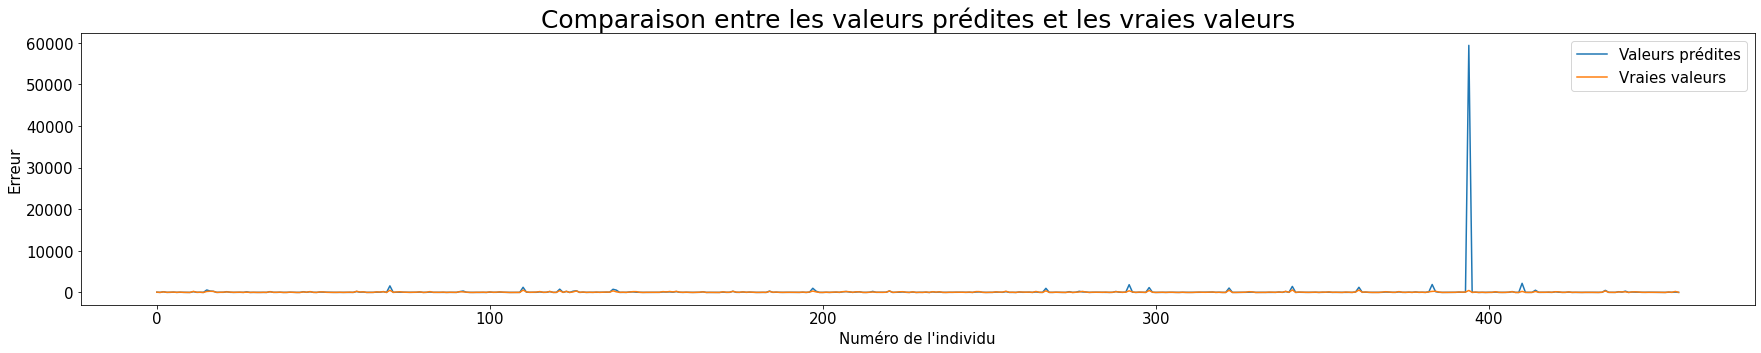

In [101]:
fig = plt.figure(figsize = (30, 5))
plt.title('Comparaison entre les valeurs prédites et les vraies valeurs', fontsize = 25)
plt.plot(np.exp(list(y_TotalGHGEmissions_pred)))
plt.plot(np.exp(list(y_TotalGHGEmissions_test)))
plt.legend(["Valeurs prédites", "Vraies valeurs"], loc = "upper right", fontsize = 15)
plt.xlabel('Numéro de l\'individu', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

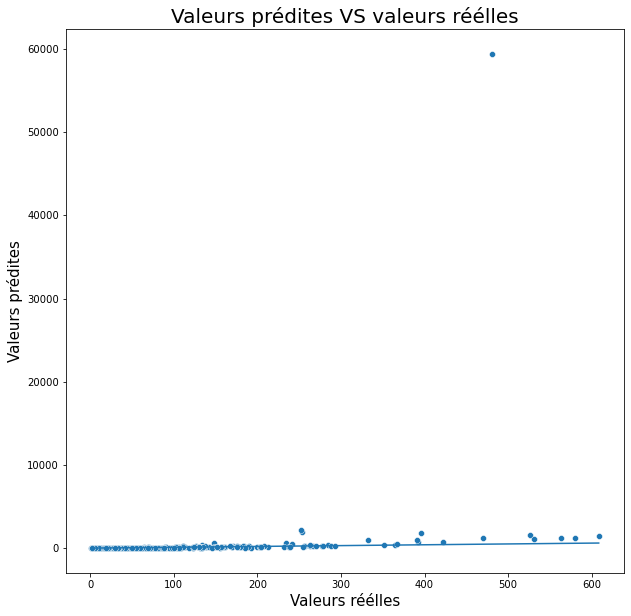

In [102]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_TotalGHGEmissions_test), y = np.exp(y_TotalGHGEmissions_pred))
plt.plot([np.exp(y_TotalGHGEmissions_test).min(), np.exp(y_TotalGHGEmissions_test).max()], [np.exp(y_TotalGHGEmissions_test).min(), np.exp(y_TotalGHGEmissions_test).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

Comme pour la variable nous allons regarder ce que donne le modèle de regression linéaire sans cet "outlier":

In [103]:
y_TotalGHGEmissions_testWithoutOutlier = y_TotalGHGEmissions_test.copy()
np.exp(y_TotalGHGEmissions_testWithoutOutlier).sort_values()

425       1.24
494       1.58
669       1.61
367       1.62
1117      1.70
         ...  
799     526.85
874     530.66
29      563.78
113     579.99
254     608.53
Name: totalGHGEmissions_Standardisation, Length: 458, dtype: float64

In [104]:
del y_TotalGHGEmissions_testWithoutOutlier[1132]

In [105]:
np.exp(y_TotalGHGEmissions_testWithoutOutlier).shape

(457,)

In [106]:
y_TotalGHGEmissions_predWithoutOutlier = y_TotalGHGEmissions_pred.copy()
valeurASupprimer = np.exp(y_TotalGHGEmissions_predWithoutOutlier).max()

for i in range(y_TotalGHGEmissions_pred.shape[0]):
    if np.exp(y_TotalGHGEmissions_pred)[i] == np.exp(y_TotalGHGEmissions_predWithoutOutlier).max():
        y_TotalGHGEmissions_predWithoutOutlier = np.delete(y_TotalGHGEmissions_predWithoutOutlier, i)
        break

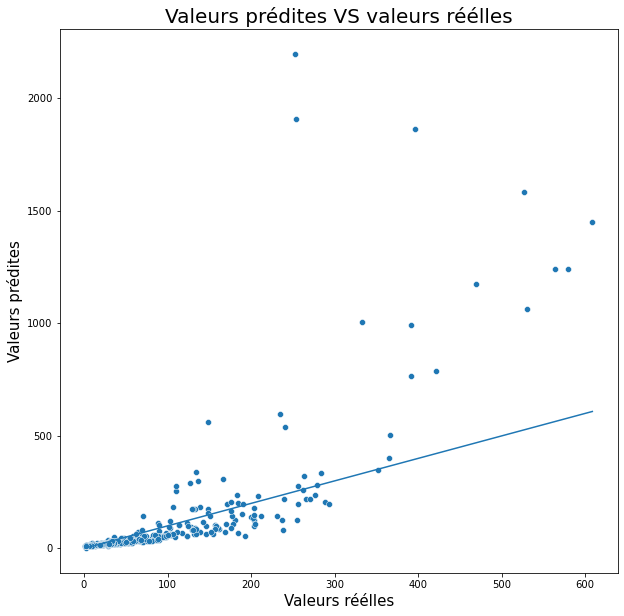

In [107]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_TotalGHGEmissions_testWithoutOutlier), y = np.exp(y_TotalGHGEmissions_predWithoutOutlier))
plt.plot([np.exp(y_TotalGHGEmissions_test).min(), np.exp(y_TotalGHGEmissions_testWithoutOutlier).max()], [np.exp(y_TotalGHGEmissions_testWithoutOutlier).min(), np.exp(y_TotalGHGEmissions_testWithoutOutlier).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

Comme nous pouvons nous y attendre et comme ce fut le cas pour le modèle de régression linéaire et la consommation d'énergie, le nuage de point est moins étiré cependant nous ne retrouvons toujours pas de linéarité entre les valeurs prédites et les vraies valeurs.

### Ridge Regressor

In [108]:
parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
              'fit_intercept' : [True, False],
              'normalize' : [True, False]
             }

gs_ridgeRegressor_TotalGHGEmissions = GridSearchCV(estimator = Ridge(), 
                  param_grid = parameters,
                  scoring = score,
                  refit = 'neg_mean_absolute_error',
                  return_train_score = True,
                  verbose = 2,
                  cv = cv_train,                                                        
                  n_jobs = -1          
                  )

gs_ridgeRegressor_TotalGHGEmissions.fit(X_TotalGHGEmissions_train, y_TotalGHGEmissions_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [109]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_ridgeRegressor_TotalGHGEmissions.best_params_)

scores = cross_val_score(gs_ridgeRegressor_TotalGHGEmissions, X_TotalGHGEmissions_train, y_TotalGHGEmissions_train, cv = cv_train)
cv_results = cross_validate(gs_ridgeRegressor_TotalGHGEmissions, X_TotalGHGEmissions_train, y_TotalGHGEmissions_train, cv = cv_train)

Nous avons les meilleurs résultats avec les paramètres: 
 {'alpha': 10, 'fit_intercept': True, 'normalize': False, 'solver': 'saga'}
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits
Fitting 5 folds for each of 196 candidates, totalling 980 fits


In [110]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(gs_ridgeRegressor_TotalGHGEmissions.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        gs_ridgeRegressor_TotalGHGEmissions.cv_results_['mean_test_neg_mean_absolute_error'], # score moyen
        gs_ridgeRegressor_TotalGHGEmissions.cv_results_['std_test_neg_mean_absolute_error'],  # écart-type du score
        gs_ridgeRegressor_TotalGHGEmissions.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std,
        params
    ) )


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 10, 'fit_intercept': True, 'normalize': False, 'solver': 'saga'}
Résultats de la validation croisée :
('r2', 'neg_mean_absolute_error') = -0.495 (+/-0.036) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'auto'}
('r2', 'neg_mean_absolute_error') = -0.495 (+/-0.036) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'svd'}
('r2', 'neg_mean_absolute_error') = -0.495 (+/-0.036) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'cholesky'}
('r2', 'neg_mean_absolute_error') = -0.494 (+/-0.036) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'lsqr'}
('r2', 'neg_mean_absolute_error') = -0.494 (+/-0.036) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'sparse_cg'}
('r2', 'neg_mean_absolute_error') = -0.495 (+/-0.036) for {'alpha': 0.0001, 'fit_intercept': True, 'normalize': True, 'solver': 'sag'}
('r2', '

In [111]:
print("MSE : ", mean_squared_error(y_TotalGHGEmissions_test, gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_TotalGHGEmissions_test, gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))))

y_TotalGHGEmissions_pred = gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)

print("MAE Train: ", mae(y_TotalGHGEmissions_train, gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_train)))
print("MAE Test: ", mae(y_TotalGHGEmissions_test, gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_TotalGHGEmissions_test), np.exp(gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_TotalGHGEmissions_test), np.exp(gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))))
print("MAE Train réelle: ", mae(np.exp(y_TotalGHGEmissions_train), np.exp(gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_train))))
print("MAE Test réelle: ", mae(np.exp(y_TotalGHGEmissions_test), np.exp(gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))))

MSE :  0.4371447601028065
RMSE :  0.661169237111654
MAE Train:  0.4799405573619292
MAE Test:  0.5050179826404003 

"Erreur réelle: "

MSE réelle:  4405376.259238734
RMSE réelle:  2098.8988206292206
MAE Train réelle:  53.86901473193422
MAE Test réelle:  146.90735106472513


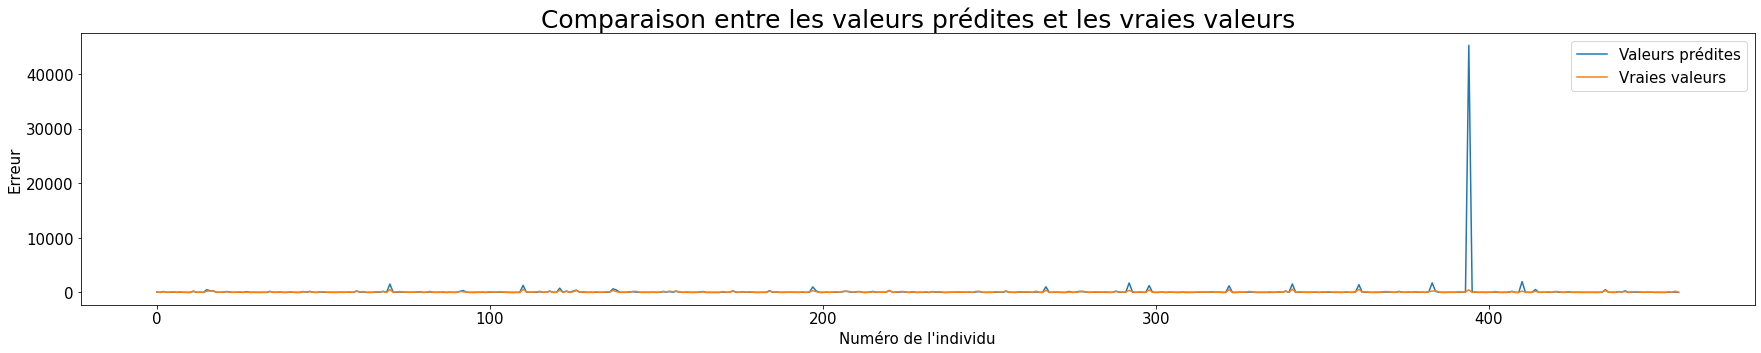

In [112]:
fig = plt.figure(figsize = (30, 5))
plt.title('Comparaison entre les valeurs prédites et les vraies valeurs', fontsize = 25)
plt.plot(np.exp(list(y_TotalGHGEmissions_pred)))
plt.plot(np.exp(list(y_TotalGHGEmissions_test)))
plt.legend(["Valeurs prédites", "Vraies valeurs"], loc = "upper right", fontsize = 15)
plt.xlabel('Numéro de l\'individu', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

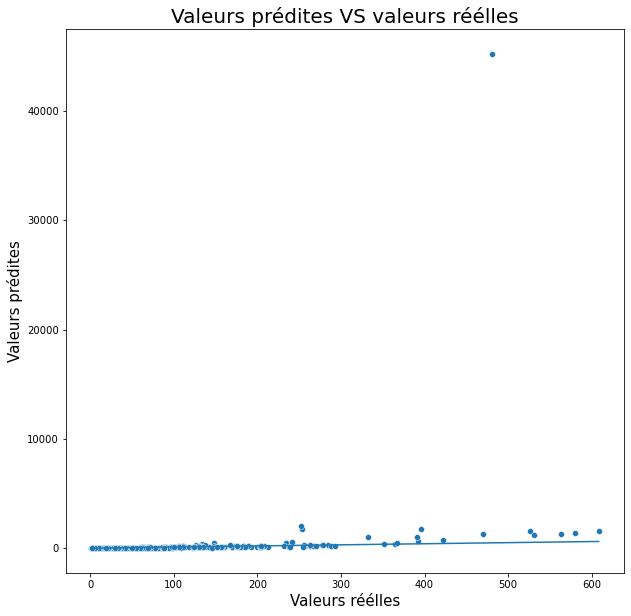

In [113]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_TotalGHGEmissions_test), y = np.exp(y_TotalGHGEmissions_pred))
plt.plot([np.exp(y_TotalGHGEmissions_test).min(), np.exp(y_TotalGHGEmissions_test).max()], [np.exp(y_TotalGHGEmissions_test).min(), np.exp(y_TotalGHGEmissions_test).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

In [114]:
y_TotalGHGEmissions_testWithoutOutlier = y_TotalGHGEmissions_test.copy()
np.exp(y_TotalGHGEmissions_testWithoutOutlier).sort_values()

425       1.24
494       1.58
669       1.61
367       1.62
1117      1.70
         ...  
799     526.85
874     530.66
29      563.78
113     579.99
254     608.53
Name: totalGHGEmissions_Standardisation, Length: 458, dtype: float64

In [115]:
del y_TotalGHGEmissions_testWithoutOutlier[1132]

In [116]:
np.exp(y_TotalGHGEmissions_testWithoutOutlier).shape

(457,)

In [117]:
y_TotalGHGEmissions_predWithoutOutlier = y_TotalGHGEmissions_pred.copy()
valeurASupprimer = np.exp(y_TotalGHGEmissions_predWithoutOutlier).max()

In [118]:
for i in range(y_TotalGHGEmissions_pred.shape[0]):
    if np.exp(y_TotalGHGEmissions_pred)[i] == np.exp(y_TotalGHGEmissions_predWithoutOutlier).max():
        y_TotalGHGEmissions_predWithoutOutlier = np.delete(y_TotalGHGEmissions_predWithoutOutlier, i)
        break

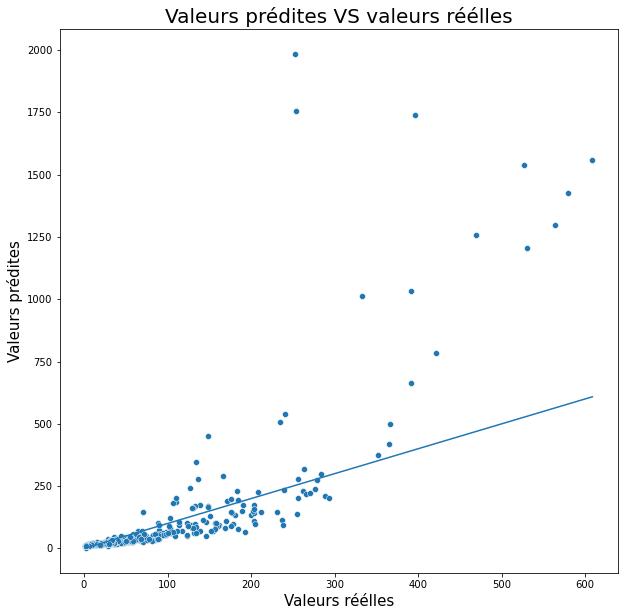

In [119]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_TotalGHGEmissions_testWithoutOutlier), y = np.exp(y_TotalGHGEmissions_predWithoutOutlier))
plt.plot([np.exp(y_TotalGHGEmissions_test).min(), np.exp(y_TotalGHGEmissions_testWithoutOutlier).max()], [np.exp(y_TotalGHGEmissions_testWithoutOutlier).min(), np.exp(y_TotalGHGEmissions_testWithoutOutlier).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

Comme nous pouvons nous y attendre et comme ce fut le cas pour le modèle de régression linéaire, le nuage de point est moins étiré cependant nous ne retrouvons toujours pas de linéarité entre les valeurs prédites et les vraies valeurs.

### Random Forest Regressor

{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800} (meilleurs paramètres pour plusieurs test, pour une question de temps nous n'allons garder que quelques paramètres et non tous)

In [120]:
param_rfr = {'n_estimators' : [500, 800, 1200],
             'max_depth' : [8, 15, None],            
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 5]}

gs_randomForestRegression_TotalGHGEmissions = GridSearchCV(RandomForestRegressor(),
                                                          param_grid = param_rfr, 
                                                          verbose = 2,
                                                          cv = cv_train,
                                                          scoring = score,
                                                          refit = 'neg_mean_absolute_error',
                                                          return_train_score = True,
                                                          n_jobs = -1
                                                          )

gs_randomForestRegression_TotalGHGEmissions.fit(X_TotalGHGEmissions_train, y_TotalGHGEmissions_train) 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 15, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [500, 800, 1200]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [121]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_randomForestRegression_TotalGHGEmissions.best_params_)

Nous avons les meilleurs résultats avec les paramètres: 
 {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}


In [122]:
listeAccuracyTrain = []

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(gs_randomForestRegression_TotalGHGEmissions.best_params_, '\n')

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_test_neg_mean_absolute_error'], # score moyen
        gs_randomForestRegression_TotalGHGEmissions.cv_results_['std_test_neg_mean_absolute_error'],  # écart-type du score
        gs_randomForestRegression_TotalGHGEmissions.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )
    listeAccuracyTrain.append(mean)
    

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200} 

Résultats de la validation croisée :
('r2', 'neg_mean_absolute_error') = -0.068 (+/-0.011) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
('r2', 'neg_mean_absolute_error') = -0.069 (+/-0.009) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
('r2', 'neg_mean_absolute_error') = -0.068 (+/-0.010) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}
('r2', 'neg_mean_absolute_error') = -0.069 (+/-0.012) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
('r2', 'neg_mean_absolute_error') = -0.069 (+/-0.012) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 

In [123]:
print("MSE : ", mean_squared_error(y_TotalGHGEmissions_test, gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_TotalGHGEmissions_test, gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))))

y_TotalGHGEmissions_pred = gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)

print("MAE Train: ", mae(y_TotalGHGEmissions_train, gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_train)))
print("MAE Test: ", mae(y_TotalGHGEmissions_test, gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_TotalGHGEmissions_test), np.exp(gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_TotalGHGEmissions_test), np.exp(gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))))
print("MAE Train réelle: ", mae(np.exp(y_TotalGHGEmissions_train), np.exp(gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_train))))
print("MAE Test réelle: ", mae(np.exp(y_TotalGHGEmissions_test), np.exp(gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))))

MSE :  0.00535947581884613
RMSE :  0.07320844089888905
MAE Train:  0.018300461606693606
MAE Test:  0.04321700139102224 

"Erreur réelle: "

MSE réelle:  156.43982891575644
RMSE réelle:  12.507590851789022
MAE Train réelle:  1.96837771014386
MAE Test réelle:  4.200799909913662


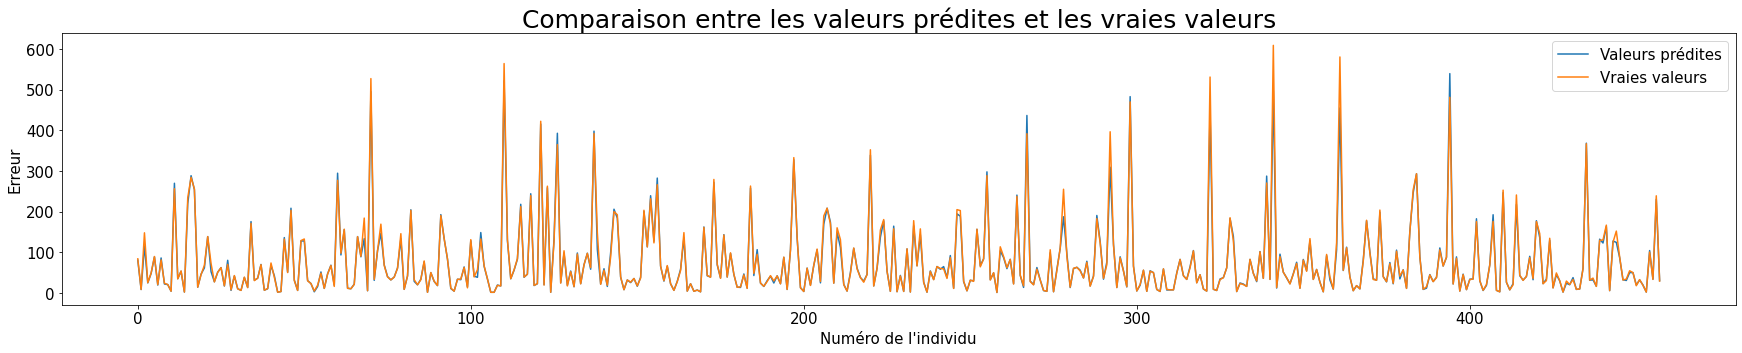

In [124]:
fig = plt.figure(figsize = (30, 5))
plt.title('Comparaison entre les valeurs prédites et les vraies valeurs', fontsize = 25)
plt.plot(np.exp(list(y_TotalGHGEmissions_pred)))
plt.plot(np.exp(list(y_TotalGHGEmissions_test)))
plt.legend(["Valeurs prédites", "Vraies valeurs"], loc = "upper right", fontsize = 15)
plt.xlabel('Numéro de l\'individu', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

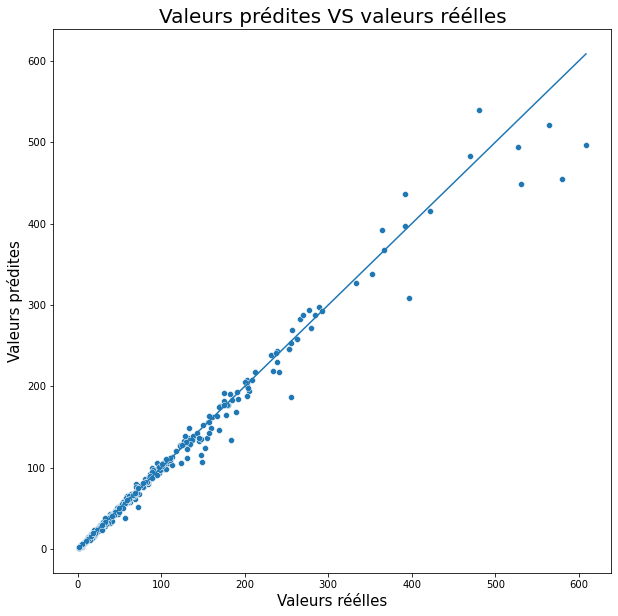

In [125]:
fig = plt.figure(figsize = (10, 10))
sns.scatterplot(x = np.exp(y_TotalGHGEmissions_test), y = np.exp(y_TotalGHGEmissions_pred))
plt.plot([np.exp(y_TotalGHGEmissions_test).min(), np.exp(y_TotalGHGEmissions_test).max()], [np.exp(y_TotalGHGEmissions_test).min(), np.exp(y_TotalGHGEmissions_test).max()])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

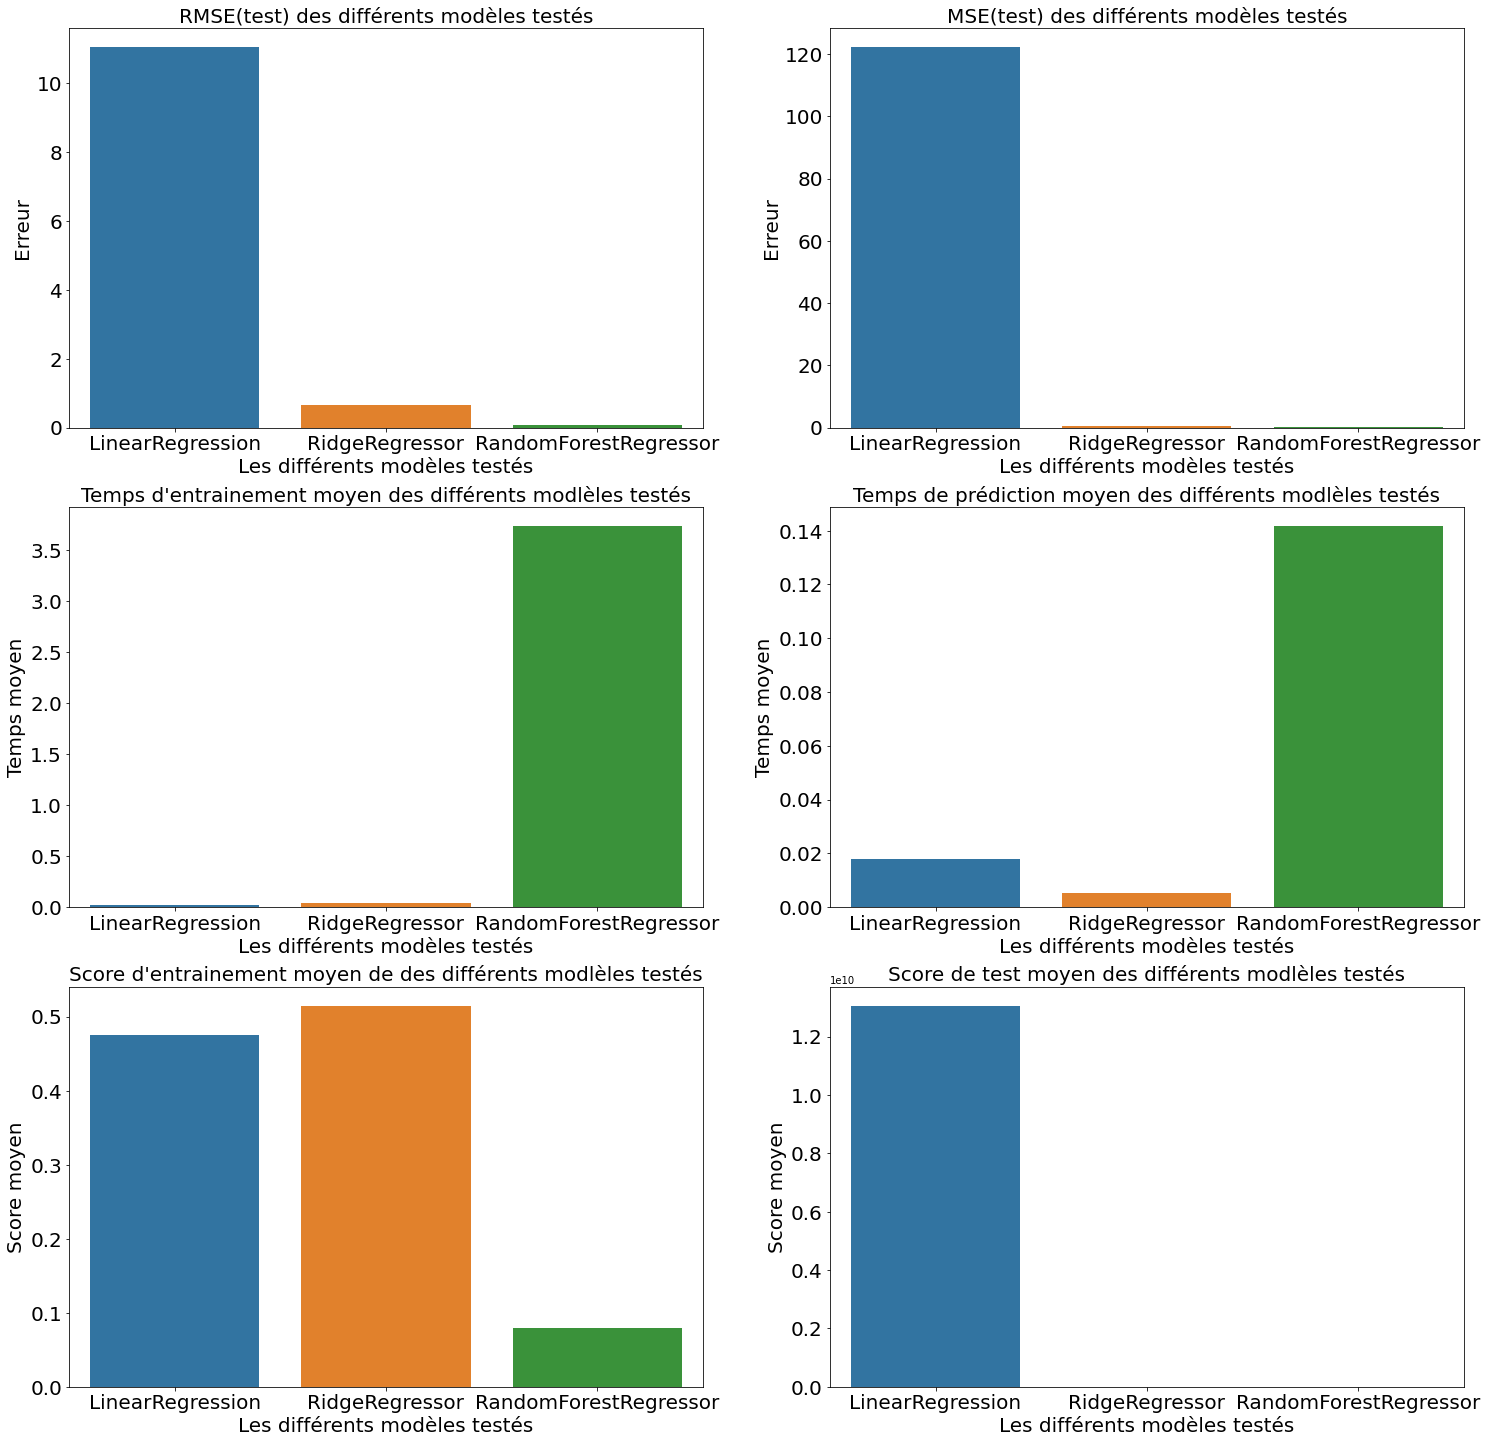

In [160]:
fig = plt.figure(figsize = (25, 25))

listeModeles = ['LinearRegression', 'RidgeRegressor', 'RandomForestRegressor']
listeRMSE = [math.sqrt(mean_squared_error(y_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))), math.sqrt(mean_squared_error(y_TotalGHGEmissions_test, gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))), math.sqrt(mean_squared_error(y_TotalGHGEmissions_test, gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)))]
listeMSE = [mean_squared_error(y_test, gs_linearRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)), mean_squared_error(y_TotalGHGEmissions_test, gs_ridgeRegressor_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)), mean_squared_error(y_TotalGHGEmissions_test, gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))]
listeFitTime = [gs_linearRegression_TotalGHGEmissions.cv_results_['mean_fit_time'].mean(), gs_ridgeRegressor_TotalGHGEmissions.cv_results_['mean_fit_time'].mean(), gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_fit_time'].mean()]
listePredictTime = [gs_linearRegression_TotalGHGEmissions.cv_results_['mean_score_time'].mean(), gs_ridgeRegressor_TotalGHGEmissions.cv_results_['mean_score_time'].mean(), gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_score_time'].mean()]
listeMeanTrain = [-1*gs_linearRegression_TotalGHGEmissions.cv_results_['mean_train_neg_mean_absolute_error'].mean(), -1*gs_ridgeRegressor_TotalGHGEmissions.cv_results_['mean_train_neg_mean_absolute_error'].mean(), -1*gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_train_neg_mean_absolute_error'].mean()]
listeMeanTest = [-1*gs_linearRegression_TotalGHGEmissions.cv_results_['mean_test_neg_mean_absolute_error'].mean(), -1*gs_ridgeRegressor_TotalGHGEmissions.cv_results_['mean_test_neg_mean_absolute_error'].mean(), -1*gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_test_neg_mean_absolute_error'].mean()]

plt.subplot(3,2,1)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(3,2,2)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Erreur', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(3,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps moyen', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(3,2,4)
sns.barplot(x = listeModeles, y = listePredictTime)
plt.title('Temps de prédiction moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Temps moyen', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(3,2,5)
sns.barplot(x = listeModeles, y = listeMeanTrain)
plt.title('Score d\'entrainement moyen de des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Score moyen', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(3,2,6)
sns.barplot(x = listeModeles, y = listeMeanTest)
plt.title('Score de test moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 20)
plt.ylabel('Score moyen', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)

Encore une fois nous obtenons le meilleur score (RMSE et MAE) avec le modèle RandomForestRegressor, nous opterons pour ce modèle.

### Intérêt de Energy Star Score

Dans un premier temps nous avons calculé le RMSE avec différents modèles de regression, sans la variable Energy Star Score, nous allons maintenant faire la même étude mais ce coup ci avec cette dernière afin de voir si elle apporte quelque chose, où au contraire rien du tout.

Dans un premier temps nous allons supprimer les individus ayant des valeurs manquantes pour la variable:

In [127]:
listeIndexNan_Energy = Data.loc[Data['ENERGYSTARScore'].isna()].index.tolist()

In [128]:
Data_copy = Data.copy()

Data_copy.shape

for i in listeIndexNan_Energy:
    Data_copy.drop(i, inplace = True)  

In [129]:
y_energyStarScore = y.copy()
X_energyStarScore = X.copy()
X_energyStarScore['energy_star_score'] = Data['ENERGYSTARScore']

In [130]:
for i in listeIndexNan_Energy:
    y_energyStarScore.drop(i, inplace = True)
    X_energyStarScore.drop(i, inplace = True)

In [131]:
X_energyStarScore_train, X_energyStarScore_test, y_energyStarScore_train, y_energyStarScore_test = train_test_split(X_energyStarScore, y_energyStarScore['totalGHGEmissions_Standardisation'], test_size = 0.3, random_state = 42)

Nous allons maintenant mesurer le nouveau RMSE avec le modèle Random Forest que nous avons choisi:

{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800} (meilleurs paramètres pour plusieurs test, pour une question de temps nous n'allons garder que quelques paramètres et non tous)

In [132]:
param_rfr = {'n_estimators' : [500, 800, 1200],
             'max_depth' : [8, 15, None],            
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': [1, 2],
             'min_samples_split': [2, 5]}

gs_randomForestRegression_energyStarScore = GridSearchCV(RandomForestRegressor(),
                                                         param_grid = param_rfr,   
                                                         verbose = 2,
                                                         cv = cv_train,
                                                         scoring = score,
                                                         refit = 'neg_mean_absolute_error',
                                                         return_train_score = True,
                                                         n_jobs = -1
                                                        )

gs_randomForestRegression_energyStarScore.fit(X_energyStarScore_train, y_energyStarScore_train) 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 15, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [500, 800, 1200]},
             refit='neg_mean_absolute_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error'), verbose=2)

In [133]:
print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_randomForestRegression_energyStarScore.best_params_)

Nous avons les meilleurs résultats avec les paramètres: 
 {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [134]:
listeAccuracyTest = []

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(gs_randomForestRegression_energyStarScore.best_params_, '\n')

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        gs_randomForestRegression_energyStarScore.cv_results_['mean_test_neg_mean_absolute_error'], # score moyen
        gs_randomForestRegression_energyStarScore.cv_results_['std_test_neg_mean_absolute_error'],  # écart-type du score
        gs_randomForestRegression_energyStarScore.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )
    listeAccuracyTest.append(mean)
    

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800} 

Résultats de la validation croisée :
('r2', 'neg_mean_absolute_error') = -0.069 (+/-0.009) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
('r2', 'neg_mean_absolute_error') = -0.069 (+/-0.011) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}
('r2', 'neg_mean_absolute_error') = -0.069 (+/-0.010) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}
('r2', 'neg_mean_absolute_error') = -0.070 (+/-0.011) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
('r2', 'neg_mean_absolute_error') = -0.070 (+/-0.012) for {'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'mi

In [135]:
print("MSE : ", mean_squared_error(y_energyStarScore_test, gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test))) # exp sur les variables log
print("RMSE : ", math.sqrt(mean_squared_error(y_energyStarScore_test, gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test))))

y_energyStarScore_pred = gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test)

print("MAE Train: ", mae(y_energyStarScore_train, gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_train)))
print("MAE Test: ", mae(y_energyStarScore_test, gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test)), '\n')

print('"Erreur réelle: "\n')

print("MSE réelle: ", mean_squared_error(np.exp(y_energyStarScore_test), np.exp(gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test)))) 
print("RMSE réelle: ", math.sqrt(mean_squared_error(np.exp(y_energyStarScore_test), np.exp(gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test)))))
print("MAE Train réelle: ", mae(np.exp(y_energyStarScore_train), np.exp(gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_train))))
print("MAE Test réelle: ", mae(np.exp(y_energyStarScore_test), np.exp(gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test))))

MSE :  0.0055746354748452565
RMSE :  0.07466348153445067
MAE Train:  0.018616697048955962
MAE Test:  0.04386172291652801 

"Erreur réelle: "

MSE réelle:  165.24133134648693
RMSE réelle:  12.85462295621645
MAE Train réelle:  2.047209473328899
MAE Test réelle:  4.3079828635104045


D'après notre nouveau RMSE il n'est pas exagéré de dire que la variable ENERGYSTARScore est pertinent.

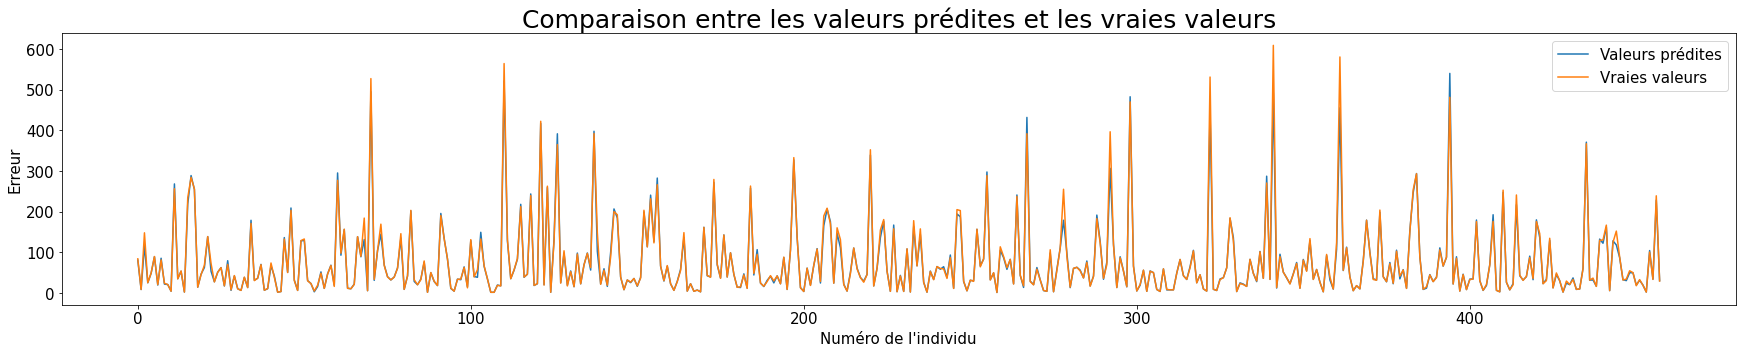

In [136]:
fig = plt.figure(figsize = (30, 5))
plt.title('Comparaison entre les valeurs prédites et les vraies valeurs', fontsize = 25)
plt.plot(np.exp(list(y_energyStarScore_pred)))
plt.plot(np.exp(list(y_energyStarScore_test)))
plt.legend(["Valeurs prédites", "Vraies valeurs"], loc = "upper right", fontsize = 15)
plt.xlabel('Numéro de l\'individu', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

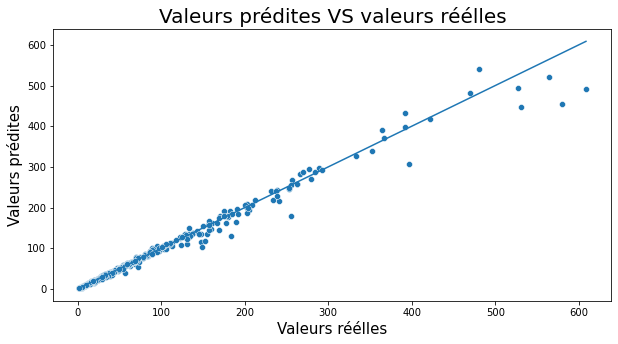

In [137]:
fig = plt.figure(figsize = (10, 5))
sns.scatterplot(x = np.exp(y_energyStarScore_test), y = np.exp(y_energyStarScore_pred))
plt.plot([np.exp(y_energyStarScore_test.min()), np.exp(y_energyStarScore_test.max())], [np.exp(y_energyStarScore_test.min()), np.exp(y_energyStarScore_test.max())])
plt.title("Valeurs prédites VS valeurs réélles", fontsize = 20)
plt.xlabel("Valeurs réélles", fontsize = 15)
plt.ylabel("Valeurs prédites", fontsize = 15)
plt.show()

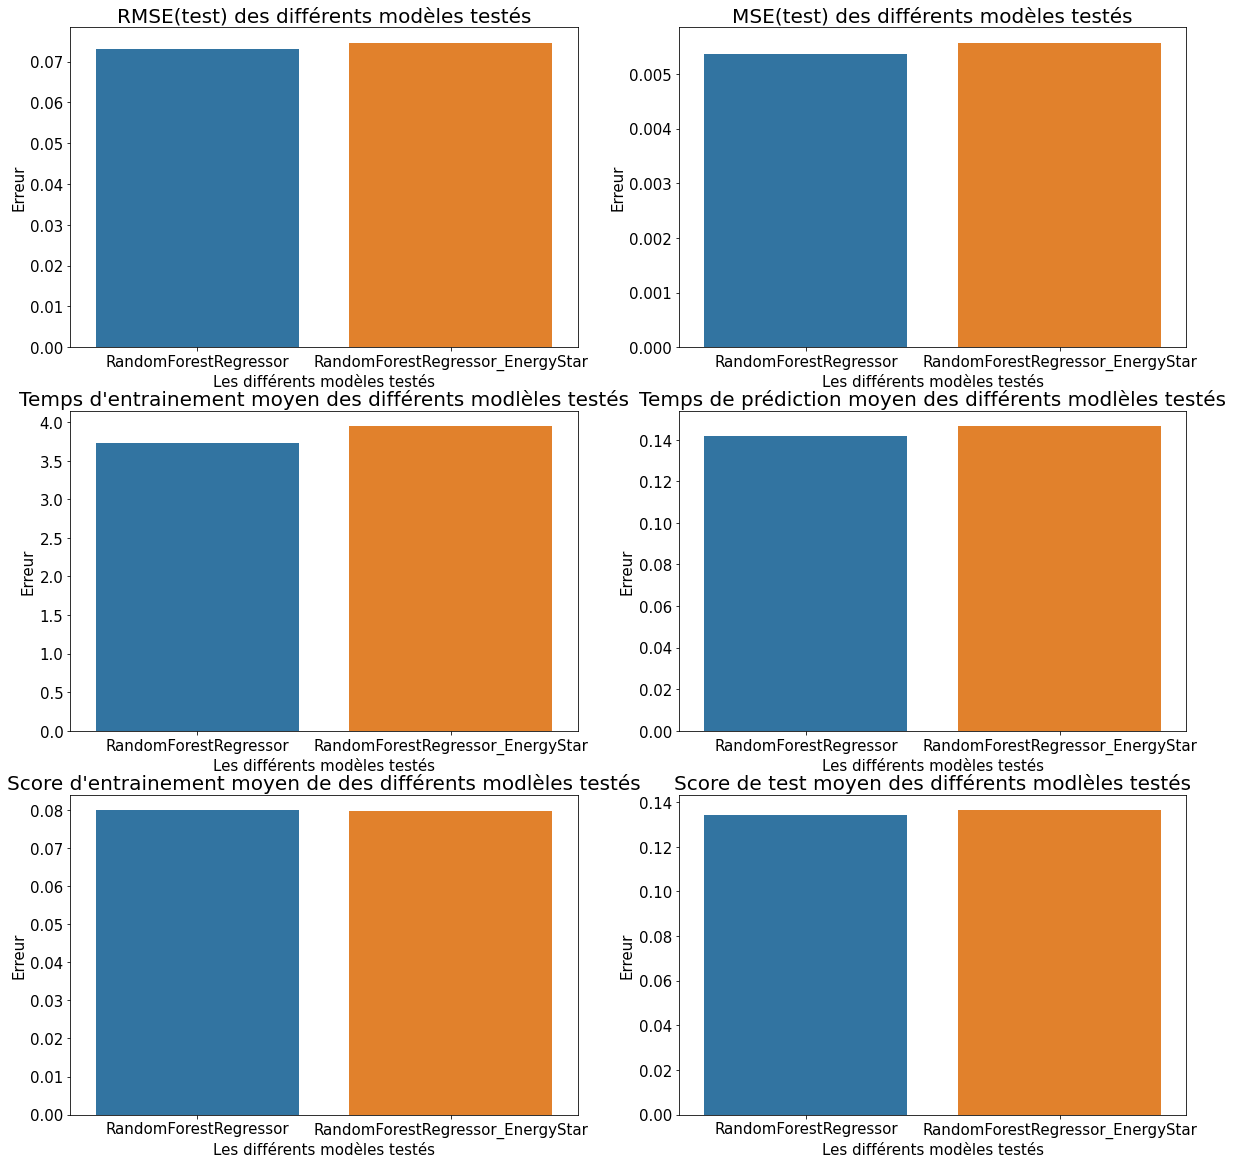

In [138]:
fig = plt.figure(figsize = (20, 20))


listeModeles = ['RandomForestRegressor', 'RandomForestRegressor_EnergyStar']
listeRMSE = [math.sqrt(mean_squared_error(y_TotalGHGEmissions_test, gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test))), math.sqrt(mean_squared_error(y_energyStarScore_test, gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test)))]
listeMSE = [mean_squared_error(y_TotalGHGEmissions_test, gs_randomForestRegression_TotalGHGEmissions.predict(X_TotalGHGEmissions_test)), mean_squared_error(y_energyStarScore_test, gs_randomForestRegression_energyStarScore.predict(X_energyStarScore_test))]
listeFitTime = [gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_fit_time'].mean(), gs_randomForestRegression_energyStarScore.cv_results_['mean_fit_time'].mean()]
listePredictTime = [gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_score_time'].mean(), gs_randomForestRegression_energyStarScore.cv_results_['mean_score_time'].mean()]
listeMeanTrain = [-1*gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_train_neg_mean_absolute_error'].mean(), -1*gs_randomForestRegression_energyStarScore.cv_results_['mean_train_neg_mean_absolute_error'].mean()]
listeMeanTest = [-1*gs_randomForestRegression_TotalGHGEmissions.cv_results_['mean_test_neg_mean_absolute_error'].mean(), -1*gs_randomForestRegression_energyStarScore.cv_results_['mean_test_neg_mean_absolute_error'].mean()]

plt.subplot(3,2,1)
sns.barplot(x = listeModeles, y = listeRMSE)
plt.title('RMSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,2)
sns.barplot(x = listeModeles, y = listeMSE)
plt.title('MSE(test) des différents modèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,3)
sns.barplot(x = listeModeles, y = listeFitTime)
plt.title('Temps d\'entrainement moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,4)
sns.barplot(x = listeModeles, y = listePredictTime)
plt.title('Temps de prédiction moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,5)
sns.barplot(x = listeModeles, y = listeMeanTrain)
plt.title('Score d\'entrainement moyen de des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(3,2,6)
sns.barplot(x = listeModeles, y = listeMeanTest)
plt.title('Score de test moyen des différents modlèles testés', fontsize = 20)
plt.xlabel('Les différents modèles testés', fontsize = 15)
plt.ylabel('Erreur', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)

Nous pouvons voir un intérêt tout à fait relative à EnergyStar au vu de la difficulté d'obtention de cette dernière.